In [14]:
## DGE for each time point to control (only old mice)
## MA Script to find the error
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

## Some Plotting Parameters
plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams.update({'font.size': 14})
plt.rcParams['pdf.fonttype'] = 42
sb.set_style("ticks")
rocket = sb.color_palette("rocket", as_cmap = True)

#pd.set_option("display.max_columns", 100)

#import diffxpy.api as de
#print(de.__version__)  ## before: v0.7.4

import diffxpy.api as de
print(de.__version__)  ## before: v0.7.4
sc.logging.print_version_and_date()

v0.7.4
Running Scanpy 1.10.2, on 2024-08-15 09:29.


In [15]:
import sparse
sparse.__version__

'0.9.1'

In [16]:
object_folder = "/media/HDD_1/Janine/Aging_SingleCell/data_objects/"

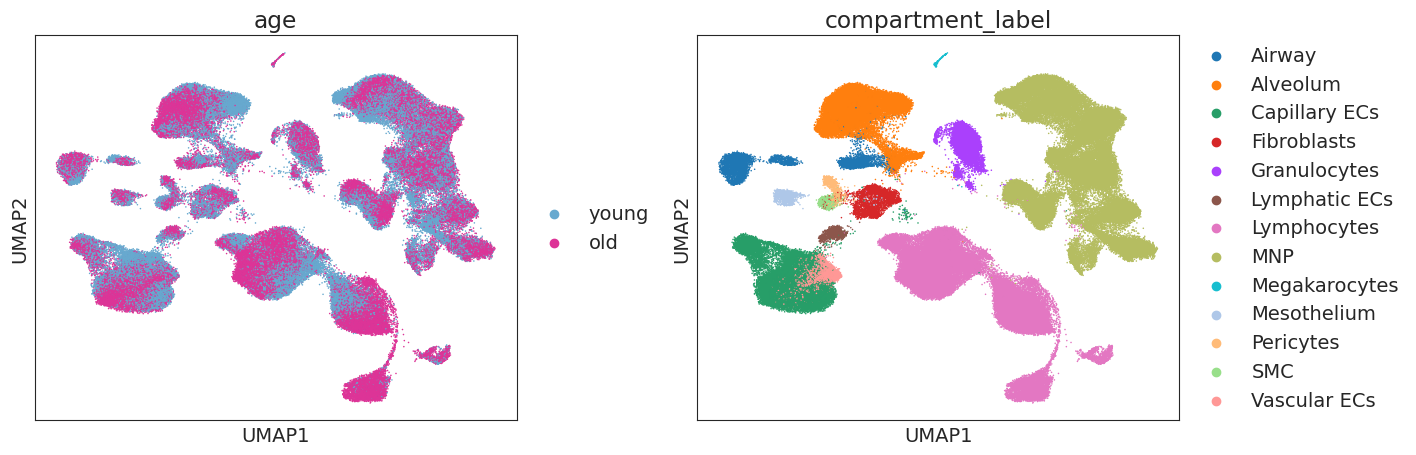

In [17]:
adata = sc.read(object_folder + "230111_Bleo_Ageing_annotated_final.h5ad", cache = False)
sc.pl.umap(adata, color = ["age", "compartment_label"], size = 5, wspace = 0.25)

In [18]:
adata

AnnData object with n_obs × n_vars = 160477 × 29814
    obs: 'age', 'barcode', 'batch', 'day', 'name', 'sex', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'doublet_scores', 'size_factors', 'S_score', 'G2M_score', 'phase', 'time_point', 'leiden_1', 'leiden_2', 'domain', 'cell_type', 'ct_level2', 'compartment_label', 'meta_label', 'age_treatment', 'age_day'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'age_colors', 'age_day_colors', 'age_treatment_colors', 'batch_colors', 'cell_type_colors', 'compartment_label_colors', 'ct_level2_colors', 'day_colors', 'dendrogram_cell_type', 'domain_colors', 'hvg', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'meta_label_colors', 'name_colors', 'neighbors', 'pca', 'sex_colors', 'time_point_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connect

In [19]:
### Scaling of counts is recommended for diffxpy
adata.obs["n_counts_scaled"] = adata.obs["n_counts"] / adata.obs["n_counts"].mean()

### Subset to only young mice

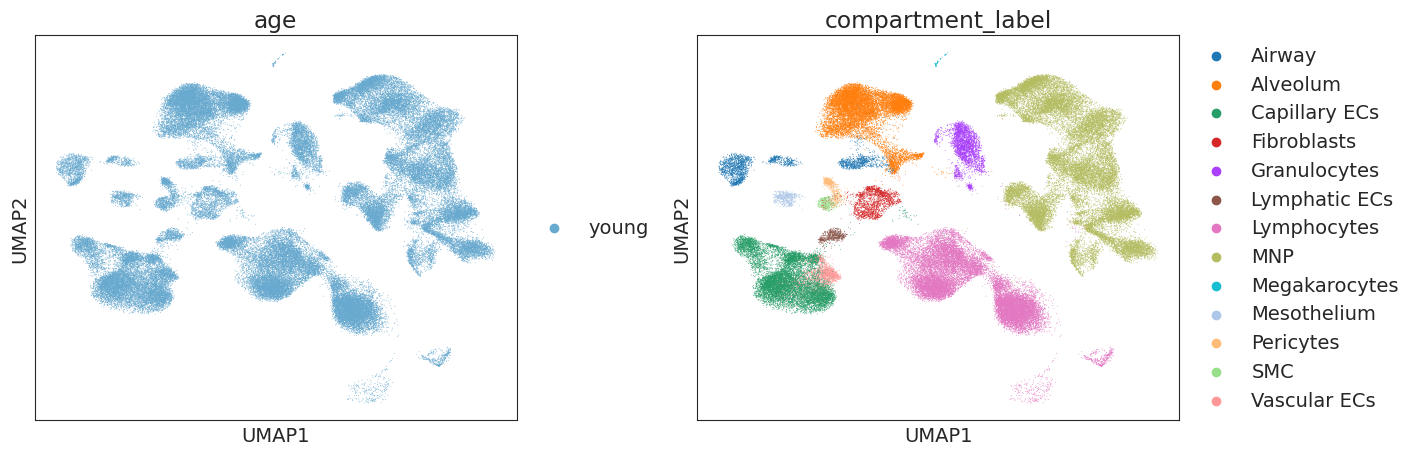

In [20]:
adata = adata[adata.obs.age == "young"].copy()
sc.pl.umap(adata, color = ["age", "compartment_label"], wspace = 0.25)

In [21]:
adata.obs.meta_label.value_counts()

meta_label
Macrophages       16757
Alveolum          12547
Capillary ECs     11176
T cells           10652
B cells            7755
DC                 6780
Monocytes          3922
Granulocytes       3054
Airway             2597
Fibroblasts        1789
Vascular ECs       1596
NK                 1567
Pericytes           611
Lymphatic ECs       603
Mesothelium         578
Plasma cells        542
SMC                 422
Megakaryocytes       45
Name: count, dtype: int64

In [22]:
list(adata.obs.meta_label.unique())

['Airway',
 'Mesothelium',
 'Macrophages',
 'T cells',
 'Alveolum',
 'DC',
 'Vascular ECs',
 'Plasma cells',
 'Lymphatic ECs',
 'Fibroblasts',
 'Capillary ECs',
 'B cells',
 'Monocytes',
 'SMC',
 'Pericytes',
 'NK',
 'Granulocytes',
 'Megakaryocytes']

### Write it into function finally

In [23]:
def dge(a, ct = "Airway", ct_label = "meta_label", condition = "treatment", ref = "control", 
        pct_thresh = 0.05, subset = ["control", "bleo"], min_cells = 10, do_return = None, 
        suffix = "", myofib = None):
    
    if myofib:
        cells = a.obs.loc[:, ct_label].isin(subset)
    else:
        cells = a.obs.loc[:, ct_label] == ct
    
    count = a[cells].obs.loc[:, condition].value_counts()
    if (len(count) < 2) or (count[0] < min_cells) or (count[1] < min_cells):
        print("Too few cells in one condition (%s)\n%s" %(ct, count))
        return
        
    ## As threshold, take 5% of all cells in cell type per group
    tab = pd.DataFrame(index = a.var_names)
    tab = codes.add_pct(a[cells], tab = tab, group_by = condition,
                        gene_label = "index", ids = subset)
    test_genes = tab[(tab.loc[:, "pct.%s" %subset[0]] > pct_thresh) | (tab.loc[:, "pct.%s" %subset[1]] > pct_thresh)].index

    if myofib:
        print("Running Myofibroblast Version")
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition,
                                                cell_type_label = ct_label, cell_type = subset, 
                                                ref = ref, min_cells = 5, subset = subset)
    
    else:
        adata_raw = codes.generate_count_object(a[:, test_genes], condition = condition, 
                                                cell_type_label = ct_label, cell_type = [ct], 
                                                ref = ref, min_cells = 5, subset = subset)

    print("Started Diffxpy Calculation:\t%s" %codes.timestamp())

    de_test = de.test.wald(data = adata_raw.X, formula_loc = "~ 1 + %s" %condition,
                           factor_loc_totest = condition,
                           training_strategy = [{"max_steps": 100, "update_b_freq": 5,
                                                "ftol_b": 1e-8, "max_iter_b": 100}],
                           gene_names = adata_raw.var_names, sample_description = adata_raw.obs,
                           noise_model = "nb", size_factors = "n_counts_scaled")

    print("Finished Diffxpy Calculation:\t%s" %codes.timestamp())

    ## Export Table
    res = codes.tidy_table(de_test, a, cells = adata_raw.obs_names, ids = subset,
                           group_by = condition, qval_thresh = 1.0)


    filename = "diffxpy_%s_vs_%s_%s_%s%s.txt" %(subset[0], subset[1], ct.replace(" ", "_"), time.replace(" ", ""), suffix)
    print("Saving to %s\n" %filename)
    res.to_csv("%s%s" %(out_folder, filename), sep = "\t", index = False)
    
    if do_return:
        return res
    

In [24]:
cell_types = ['Alveolum','Airway','Macrophages','Monocytes','DC','B cells',
              'Plasma cells','T cells','NK','Granulocytes','Fibroblasts',
              'Pericytes','SMC','Mesothelium','Capillary ECs', 'Vascular ECs','Lymphatic ECs']

In [25]:
pd.crosstab(adata.obs.meta_label, adata.obs.day)

day               d0    d3   d10   d20   d30   d37
meta_label                                        
Alveolum        7531  1777   698   563   867  1111
Airway          1103   194   249   312   370   369
Macrophages     3576  1294  3903  3421  2818  1745
Monocytes       1898   741   149   370   457   307
DC              1415   495  1552  1303  1191   824
B cells         2484  1443  1093   950   928   857
Plasma cells      75    36    35    95   138   163
T cells         2770  1419  1946  1674  1577  1266
NK               667   340    95   105   219   141
Megakaryocytes    31     6     4     2     2     0
Granulocytes    1303   559   105   394   209   484
Fibroblasts      444   170   357   512   199   107
Pericytes        225   112    79    97    68    30
SMC              212    46    40    43    53    28
Mesothelium      221    81    73    62   101    40
Capillary ECs   4345  1576  1231  1486  1551   987
Vascular ECs     583   213   248   216   253    83
Lymphatic ECs    165    42    97   124    98    77

### day 3

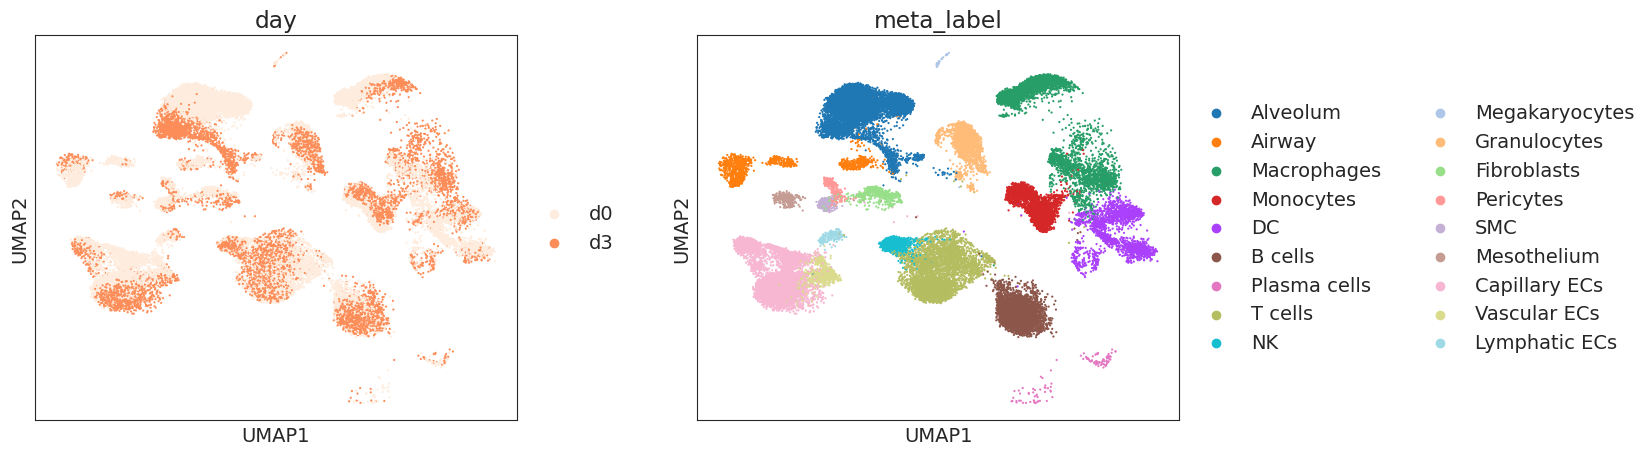

Alveolum - d3
(9308, 5072)


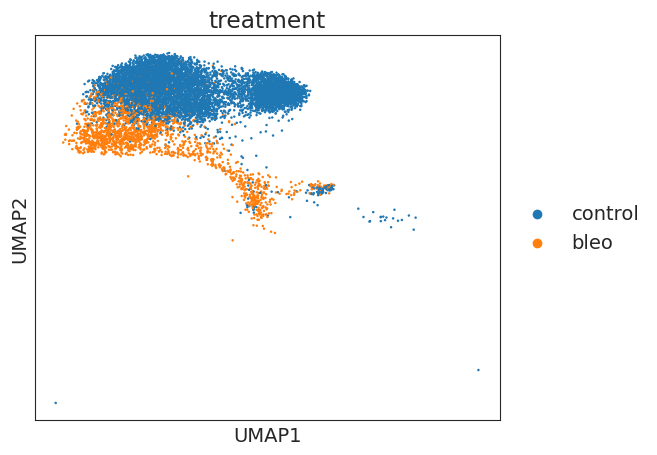

Started Diffxpy Calculation:	14-08-2024 16:37:43
training location model: True
training scale model: True
iter   0: ll=19469312.116120
iter   1: ll=17629759.438431, converged: 0.00% (loc: 0.02%, scale update: False), in 3.23sec
iter   2: ll=17205386.295399, converged: 0.00% (loc: 0.02%, scale update: False), in 3.08sec
iter   3: ll=17175992.072807, converged: 0.00% (loc: 0.02%, scale update: False), in 2.96sec
iter   4: ll=17175526.903765, converged: 0.00% (loc: 0.02%, scale update: False), in 3.11sec
iter   5: ll=17175522.290036, converged: 0.00% (loc: 0.26%, scale update: False), in 3.09sec
iter   6: ll=16901658.631603, converged: 0.00% (loc: 0.00%, scale update: True), in 49.10sec
iter   7: ll=16898559.254757, converged: 0.00% (loc: 0.00%, scale update: False), in 3.04sec
iter   8: ll=16898474.847064, converged: 0.00% (loc: 0.41%, scale update: False), in 3.04sec
iter   9: ll=16898472.587235, converged: 0.00% (loc: 2.60%, scale update: False), in 3.21sec
iter  10: ll=16898472.548263

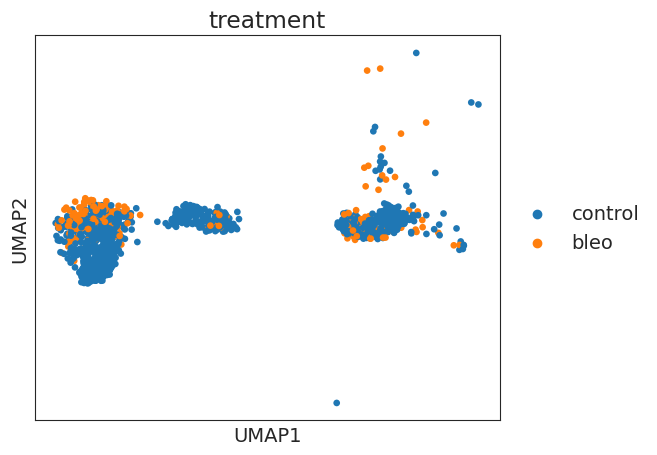

Started Diffxpy Calculation:	14-08-2024 16:42:38
training location model: True
training scale model: True
iter   0: ll=13825421.034559
caught 5 linalg singular matrix errors
iter   1: ll=12996853.167674, converged: 0.00% (loc: 5.25%, scale update: False), in 2.73sec
iter   2: ll=12708987.947299, converged: 0.00% (loc: 5.25%, scale update: False), in 2.52sec
iter   3: ll=12646279.117776, converged: 0.00% (loc: 5.25%, scale update: False), in 1.83sec
iter   4: ll=12636294.640097, converged: 0.00% (loc: 5.25%, scale update: False), in 1.61sec
iter   5: ll=12634914.461995, converged: 0.00% (loc: 5.25%, scale update: False), in 1.32sec
iter   6: ll=4665345.103197, converged: 0.00% (loc: 0.00%, scale update: True), in 12.35sec
caught 5 linalg singular matrix errors
iter   7: ll=4646797.411357, converged: 0.00% (loc: 0.09%, scale update: False), in 2.36sec
iter   8: ll=4644735.334787, converged: 0.00% (loc: 0.42%, scale update: False), in 2.03sec
iter   9: ll=4644477.855402, converged: 0.00% 

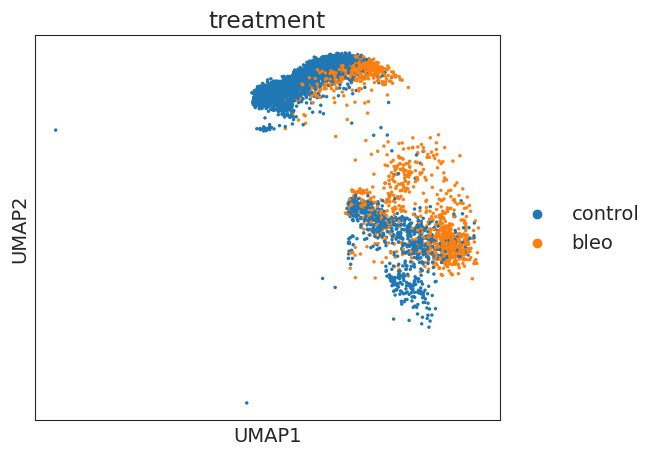

Started Diffxpy Calculation:	14-08-2024 16:44:51
training location model: True
training scale model: True
iter   0: ll=13461109.818087
caught 1 linalg singular matrix errors
iter   1: ll=12196088.381677, converged: 0.00% (loc: 0.05%, scale update: False), in 2.24sec
iter   2: ll=11894169.915700, converged: 0.00% (loc: 0.05%, scale update: False), in 2.25sec
iter   3: ll=11871092.466421, converged: 0.00% (loc: 0.05%, scale update: False), in 2.52sec
iter   4: ll=11870605.255156, converged: 0.00% (loc: 0.05%, scale update: False), in 3.23sec
iter   5: ll=11870598.570584, converged: 0.00% (loc: 0.19%, scale update: False), in 3.42sec
iter   6: ll=11687217.953542, converged: 0.00% (loc: 0.00%, scale update: True), in 28.38sec
caught 1 linalg singular matrix errors
iter   7: ll=11684897.548586, converged: 0.00% (loc: 0.02%, scale update: False), in 2.20sec
iter   8: ll=11684817.721931, converged: 0.00% (loc: 0.81%, scale update: False), in 2.35sec
iter   9: ll=11684815.164420, converged: 0.

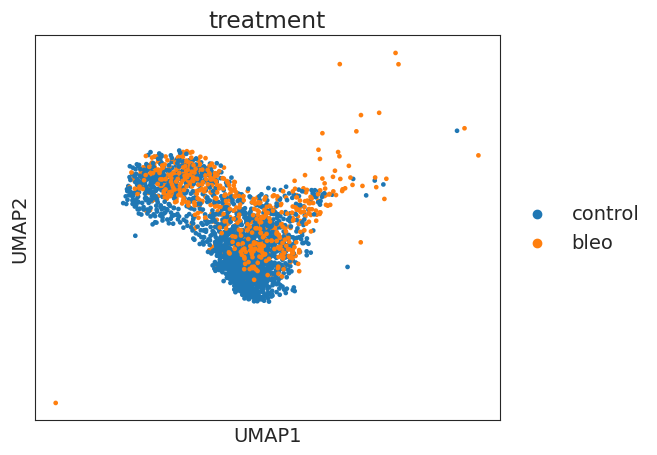

Started Diffxpy Calculation:	14-08-2024 16:48:11
training location model: True
training scale model: True
iter   0: ll=6732791.825981
iter   1: ll=5982468.553591, converged: 0.00% (loc: 0.00%, scale update: False), in 1.22sec
iter   2: ll=5816345.273422, converged: 0.00% (loc: 0.00%, scale update: False), in 1.24sec
iter   3: ll=5805900.262571, converged: 0.00% (loc: 0.00%, scale update: False), in 1.26sec
iter   4: ll=5805780.151447, converged: 0.00% (loc: 0.00%, scale update: False), in 1.41sec
iter   5: ll=5805779.514550, converged: 0.00% (loc: 0.77%, scale update: False), in 1.17sec
iter   6: ll=5776705.748127, converged: 0.00% (loc: 0.00%, scale update: True), in 14.15sec
iter   7: ll=5776293.980009, converged: 0.00% (loc: 0.07%, scale update: False), in 1.44sec
iter   8: ll=5776289.684072, converged: 0.00% (loc: 1.46%, scale update: False), in 1.31sec
iter   9: ll=5776289.646863, converged: 0.00% (loc: 14.21%, scale update: False), in 1.29sec
iter  10: ll=5776289.646507, converge

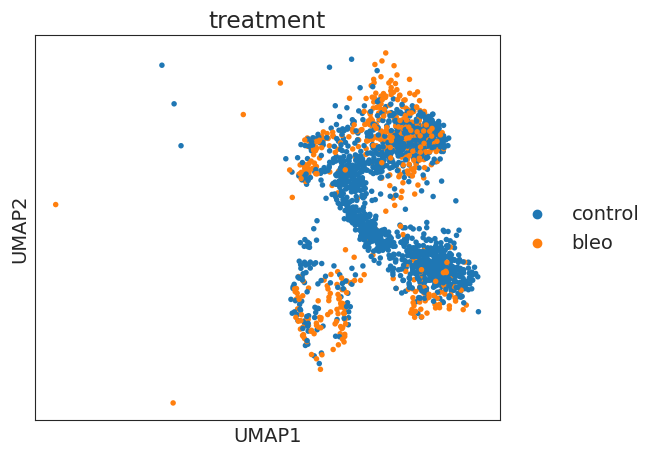

Started Diffxpy Calculation:	14-08-2024 16:49:36
training location model: True
training scale model: True
iter   0: ll=4877771.979297
iter   1: ll=4384793.753963, converged: 0.00% (loc: 0.00%, scale update: False), in 1.28sec
iter   2: ll=4271785.319848, converged: 0.00% (loc: 0.00%, scale update: False), in 1.25sec
iter   3: ll=4263841.177104, converged: 0.00% (loc: 0.00%, scale update: False), in 1.19sec
iter   4: ll=4263699.650230, converged: 0.00% (loc: 0.00%, scale update: False), in 1.40sec
iter   5: ll=4263697.644988, converged: 0.00% (loc: 0.63%, scale update: False), in 1.71sec
iter   6: ll=4243690.318602, converged: 0.00% (loc: 0.00%, scale update: True), in 11.80sec
iter   7: ll=4243332.567611, converged: 0.00% (loc: 0.06%, scale update: False), in 1.43sec
iter   8: ll=4243322.876377, converged: 0.00% (loc: 2.58%, scale update: False), in 1.42sec
iter   9: ll=4243322.600416, converged: 0.00% (loc: 11.64%, scale update: False), in 1.27sec
iter  10: ll=4243322.593318, converge

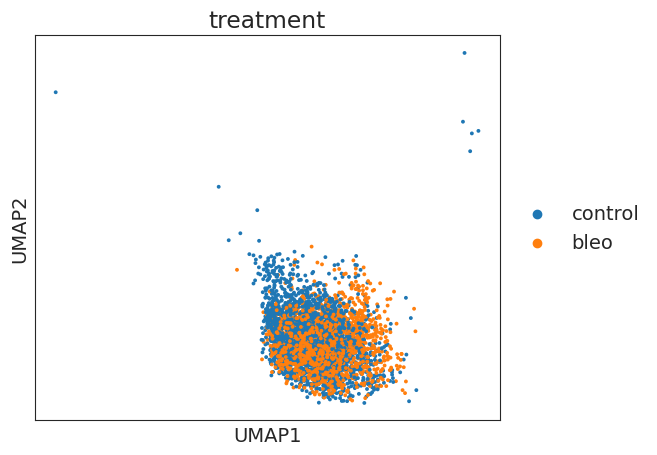

Started Diffxpy Calculation:	14-08-2024 16:51:03
training location model: True
training scale model: True
iter   0: ll=5376682.376725
iter   1: ll=4839723.001132, converged: 0.00% (loc: 0.00%, scale update: False), in 1.15sec
iter   2: ll=4716427.255173, converged: 0.00% (loc: 0.00%, scale update: False), in 1.17sec
iter   3: ll=4709945.028213, converged: 0.00% (loc: 0.00%, scale update: False), in 1.02sec
iter   4: ll=4709925.920060, converged: 0.00% (loc: 0.00%, scale update: False), in 1.22sec
iter   5: ll=4709925.917550, converged: 0.00% (loc: 41.16%, scale update: False), in 1.12sec
iter   6: ll=4626617.929602, converged: 0.00% (loc: 0.00%, scale update: True), in 13.86sec
iter   7: ll=4626573.200990, converged: 0.00% (loc: 0.00%, scale update: False), in 1.13sec
iter   8: ll=4626573.146545, converged: 0.00% (loc: 20.28%, scale update: False), in 1.15sec
iter   9: ll=4626573.146455, converged: 0.00% (loc: 96.09%, scale update: False), in 1.04sec
iter  10: ll=4626573.146455, conver

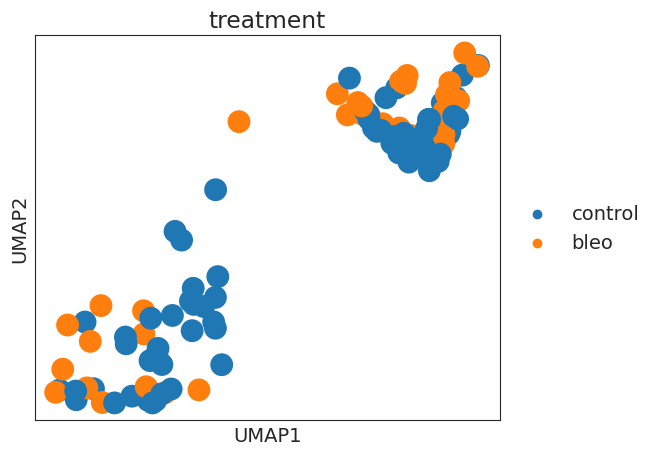

Started Diffxpy Calculation:	14-08-2024 16:51:58
training location model: True
training scale model: True
iter   0: ll=2301368.820992
caught 35 linalg singular matrix errors
iter   1: ll=2271673.648517, converged: 0.00% (loc: 26.01%, scale update: False), in 0.23sec
iter   2: ll=2261445.388647, converged: 0.00% (loc: 26.01%, scale update: False), in 0.23sec
iter   3: ll=2259483.354784, converged: 0.00% (loc: 26.01%, scale update: False), in 0.23sec
iter   4: ll=2259281.859728, converged: 0.00% (loc: 26.01%, scale update: False), in 0.23sec
iter   5: ll=2259266.964998, converged: 0.00% (loc: 26.09%, scale update: False), in 0.24sec
iter   6: ll=247177.920642, converged: 0.00% (loc: 0.00%, scale update: True), in 1.99sec
caught 33 linalg singular matrix errors
iter   7: ll=244492.230762, converged: 0.00% (loc: 6.15%, scale update: False), in 0.26sec
iter   8: ll=243894.663435, converged: 0.00% (loc: 7.29%, scale update: False), in 0.24sec
iter   9: ll=243819.092802, converged: 0.00% (loc

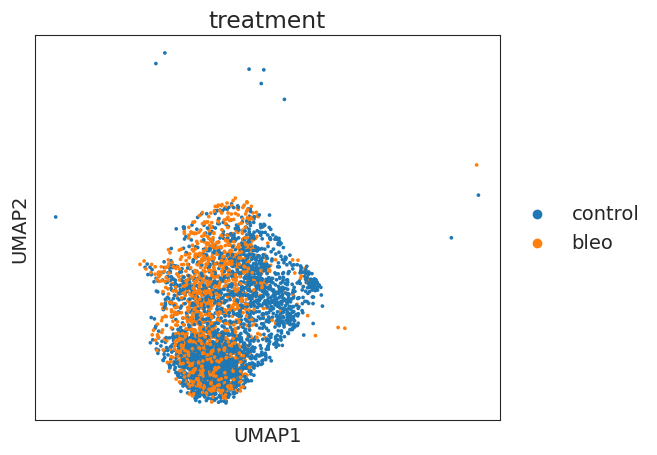

Started Diffxpy Calculation:	14-08-2024 16:52:36
training location model: True
training scale model: True
iter   0: ll=6644203.962243
iter   1: ll=6013855.307935, converged: 0.00% (loc: 0.00%, scale update: False), in 1.97sec
iter   2: ll=5875051.236180, converged: 0.00% (loc: 0.00%, scale update: False), in 1.79sec
iter   3: ll=5868133.185822, converged: 0.00% (loc: 0.00%, scale update: False), in 1.44sec
iter   4: ll=5868111.670453, converged: 0.00% (loc: 0.00%, scale update: False), in 1.83sec
iter   5: ll=5868111.665582, converged: 0.00% (loc: 30.27%, scale update: False), in 1.85sec
iter   6: ll=5775301.317166, converged: 0.00% (loc: 0.00%, scale update: True), in 15.23sec
iter   7: ll=5775206.033418, converged: 0.00% (loc: 0.00%, scale update: False), in 1.37sec
iter   8: ll=5775205.717140, converged: 0.00% (loc: 11.78%, scale update: False), in 1.28sec
iter   9: ll=5775205.715899, converged: 0.00% (loc: 83.47%, scale update: False), in 1.61sec
iter  10: ll=5775205.715889, conver

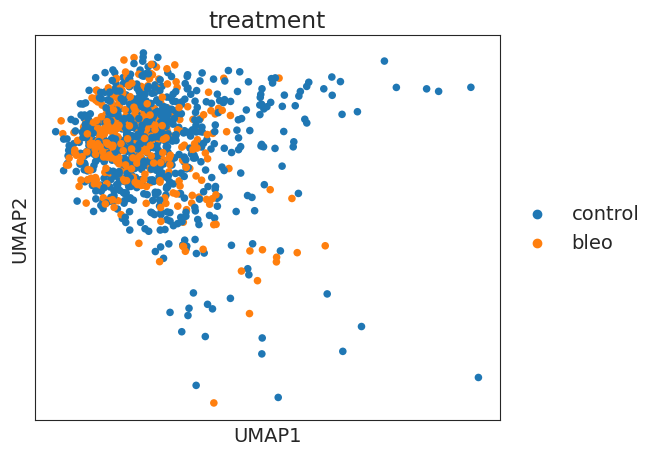

Started Diffxpy Calculation:	14-08-2024 16:53:52
training location model: True
training scale model: True
iter   0: ll=1454205.105991
iter   1: ll=1314888.024442, converged: 0.00% (loc: 0.00%, scale update: False), in 0.51sec
iter   2: ll=1283815.404373, converged: 0.00% (loc: 0.00%, scale update: False), in 0.32sec
iter   3: ll=1282233.758374, converged: 0.00% (loc: 0.00%, scale update: False), in 0.32sec
iter   4: ll=1282228.830554, converged: 0.00% (loc: 0.00%, scale update: False), in 0.39sec
iter   5: ll=1282228.829502, converged: 0.00% (loc: 34.02%, scale update: False), in 0.53sec
iter   6: ll=1258721.296144, converged: 0.00% (loc: 0.00%, scale update: True), in 6.25sec
iter   7: ll=1258698.442332, converged: 0.00% (loc: 0.07%, scale update: False), in 0.58sec
iter   8: ll=1258698.408870, converged: 0.00% (loc: 14.82%, scale update: False), in 0.59sec
iter   9: ll=1258698.408831, converged: 0.00% (loc: 93.90%, scale update: False), in 0.32sec
iter  10: ll=1258698.408830, converg

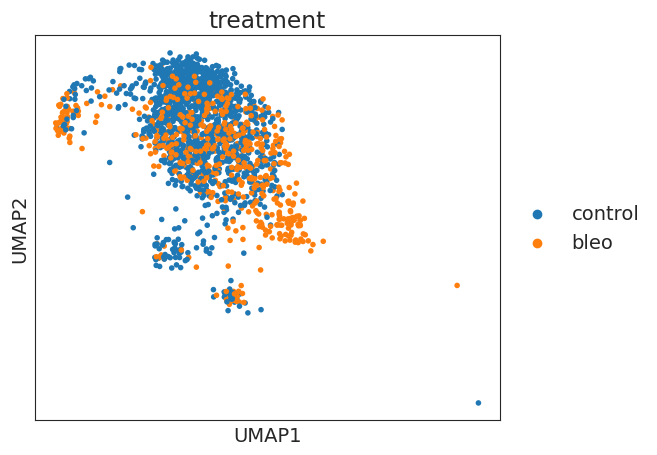

Started Diffxpy Calculation:	14-08-2024 16:54:18
training location model: True
training scale model: True
iter   0: ll=1964905.115289
iter   1: ll=1757856.566181, converged: 0.00% (loc: 0.00%, scale update: False), in 0.87sec
iter   2: ll=1706225.491732, converged: 0.00% (loc: 0.00%, scale update: False), in 0.63sec
iter   3: ll=1703023.017043, converged: 0.00% (loc: 0.00%, scale update: False), in 0.61sec
iter   4: ll=1703008.360919, converged: 0.00% (loc: 0.00%, scale update: False), in 0.81sec
iter   5: ll=1703008.358513, converged: 0.00% (loc: 19.68%, scale update: False), in 0.64sec
iter   6: ll=1671588.639571, converged: 0.00% (loc: 0.00%, scale update: True), in 4.55sec
iter   7: ll=1671574.169209, converged: 0.00% (loc: 0.00%, scale update: False), in 0.74sec
iter   8: ll=1671574.151935, converged: 0.00% (loc: 27.35%, scale update: False), in 0.66sec
iter   9: ll=1671574.151874, converged: 0.00% (loc: 98.02%, scale update: False), in 0.58sec
iter  10: ll=1671574.151874, converg

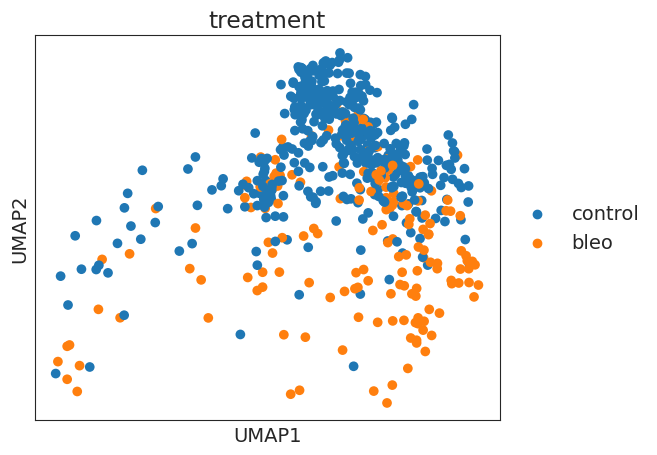

Started Diffxpy Calculation:	14-08-2024 16:54:44
training location model: True
training scale model: True
iter   0: ll=1727274.306705
caught 8 linalg singular matrix errors
iter   1: ll=1579265.104971, converged: 0.00% (loc: 0.38%, scale update: False), in 0.68sec
iter   2: ll=1542643.530886, converged: 0.00% (loc: 0.38%, scale update: False), in 0.49sec
iter   3: ll=1539597.447920, converged: 0.00% (loc: 0.38%, scale update: False), in 0.50sec
iter   4: ll=1539520.986071, converged: 0.00% (loc: 0.38%, scale update: False), in 0.50sec
iter   5: ll=1539519.378988, converged: 0.00% (loc: 1.04%, scale update: False), in 0.49sec
iter   6: ll=1436017.278521, converged: 0.00% (loc: 0.00%, scale update: True), in 6.70sec
caught 8 linalg singular matrix errors
iter   7: ll=1435525.044227, converged: 0.00% (loc: 0.20%, scale update: False), in 0.60sec
iter   8: ll=1435481.744585, converged: 0.00% (loc: 1.65%, scale update: False), in 0.57sec
iter   9: ll=1435477.217621, converged: 0.00% (loc: 8

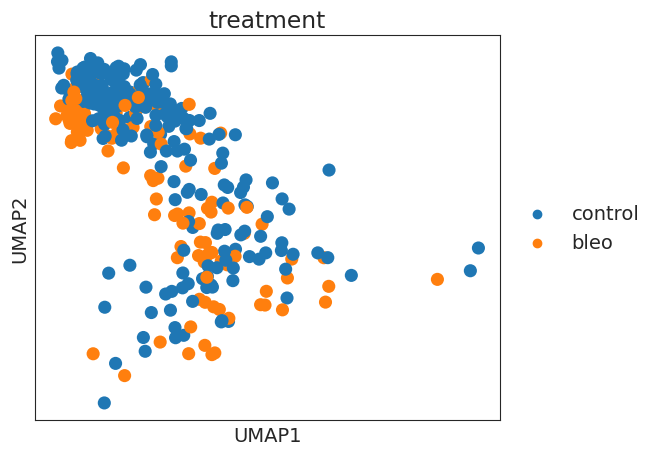

Started Diffxpy Calculation:	14-08-2024 16:55:39
training location model: True
training scale model: True
iter   0: ll=729292.444223
caught 14 linalg singular matrix errors
iter   1: ll=663409.168884, converged: 0.00% (loc: 0.33%, scale update: False), in 0.61sec
iter   2: ll=649049.473158, converged: 0.00% (loc: 0.33%, scale update: False), in 0.43sec
iter   3: ll=648257.984234, converged: 0.00% (loc: 0.33%, scale update: False), in 0.88sec
iter   4: ll=648252.271108, converged: 0.00% (loc: 0.33%, scale update: False), in 0.47sec
iter   5: ll=648252.244544, converged: 0.00% (loc: 10.60%, scale update: False), in 0.51sec
iter   6: ll=633778.981633, converged: 0.00% (loc: 0.00%, scale update: True), in 3.96sec
caught 14 linalg singular matrix errors
iter   7: ll=633691.346907, converged: 0.00% (loc: 0.56%, scale update: False), in 0.51sec
iter   8: ll=633690.250860, converged: 0.00% (loc: 3.85%, scale update: False), in 0.55sec
iter   9: ll=633690.240654, converged: 0.00% (loc: 36.07%, 

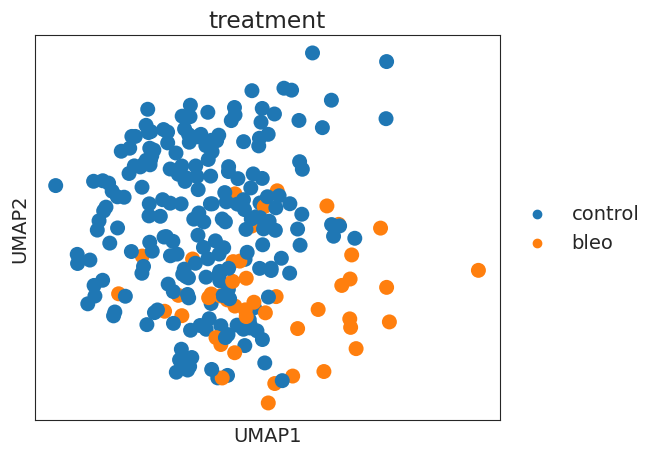

Started Diffxpy Calculation:	14-08-2024 16:56:18
training location model: True
training scale model: True
iter   0: ll=1524186.019226
caught 30 linalg singular matrix errors
iter   1: ll=1444074.017007, converged: 0.00% (loc: 5.50%, scale update: False), in 0.58sec
iter   2: ll=1423950.668288, converged: 0.00% (loc: 5.50%, scale update: False), in 0.63sec
iter   3: ll=1422052.724740, converged: 0.00% (loc: 5.50%, scale update: False), in 0.77sec
iter   4: ll=1421968.278970, converged: 0.00% (loc: 5.50%, scale update: False), in 0.60sec
iter   5: ll=1421962.366885, converged: 0.00% (loc: 5.59%, scale update: False), in 0.58sec
iter   6: ll=657185.309671, converged: 0.00% (loc: 0.00%, scale update: True), in 4.09sec
caught 30 linalg singular matrix errors
iter   7: ll=654877.184645, converged: 0.00% (loc: 0.99%, scale update: False), in 0.85sec
iter   8: ll=654344.037548, converged: 0.00% (loc: 1.97%, scale update: False), in 0.78sec
iter   9: ll=654273.372448, converged: 0.00% (loc: 9.4

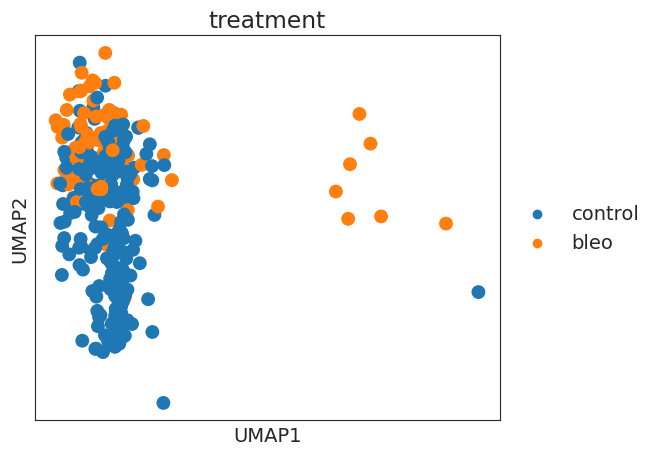

Started Diffxpy Calculation:	14-08-2024 16:57:26
training location model: True
training scale model: True
iter   0: ll=1302821.426070
caught 7 linalg singular matrix errors
iter   1: ll=1208306.114299, converged: 0.00% (loc: 2.25%, scale update: False), in 0.74sec
iter   2: ll=1184554.255764, converged: 0.00% (loc: 2.25%, scale update: False), in 0.58sec
iter   3: ll=1182325.928012, converged: 0.00% (loc: 2.25%, scale update: False), in 0.56sec
iter   4: ll=1182246.186738, converged: 0.00% (loc: 2.25%, scale update: False), in 0.55sec
iter   5: ll=1182243.290786, converged: 0.00% (loc: 2.37%, scale update: False), in 0.59sec
iter   6: ll=717196.947562, converged: 0.00% (loc: 0.00%, scale update: True), in 4.05sec
caught 7 linalg singular matrix errors
iter   7: ll=715712.576589, converged: 0.00% (loc: 0.22%, scale update: False), in 0.69sec
iter   8: ll=715405.077967, converged: 0.00% (loc: 1.16%, scale update: False), in 0.52sec
iter   9: ll=715369.481360, converged: 0.00% (loc: 8.41%

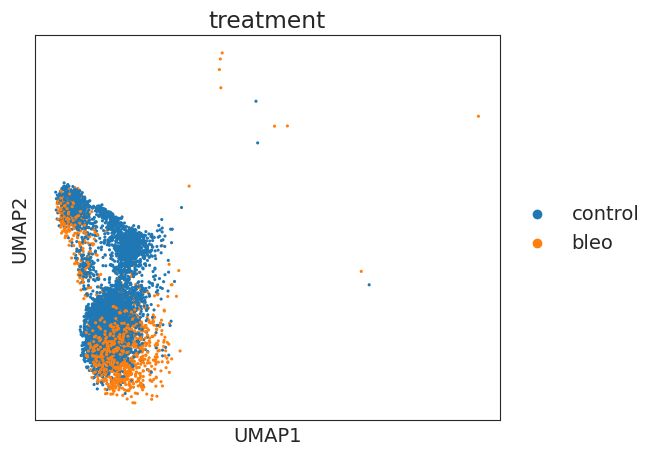

Started Diffxpy Calculation:	14-08-2024 16:58:28
training location model: True
training scale model: True
iter   0: ll=11649439.792683
iter   1: ll=10621455.957733, converged: 0.00% (loc: 0.00%, scale update: False), in 2.11sec
iter   2: ll=10389693.533596, converged: 0.00% (loc: 0.00%, scale update: False), in 1.86sec
iter   3: ll=10377186.643438, converged: 0.00% (loc: 0.00%, scale update: False), in 2.32sec
iter   4: ll=10377134.533660, converged: 0.00% (loc: 0.00%, scale update: False), in 2.07sec
iter   5: ll=10377134.516911, converged: 0.00% (loc: 10.69%, scale update: False), in 2.32sec
iter   6: ll=10161256.995568, converged: 0.00% (loc: 0.00%, scale update: True), in 23.31sec
iter   7: ll=10160810.375420, converged: 0.00% (loc: 0.05%, scale update: False), in 2.55sec
iter   8: ll=10160808.812481, converged: 0.00% (loc: 3.01%, scale update: False), in 1.78sec
iter   9: ll=10160808.808302, converged: 0.00% (loc: 45.50%, scale update: False), in 1.76sec
iter  10: ll=10160808.8082

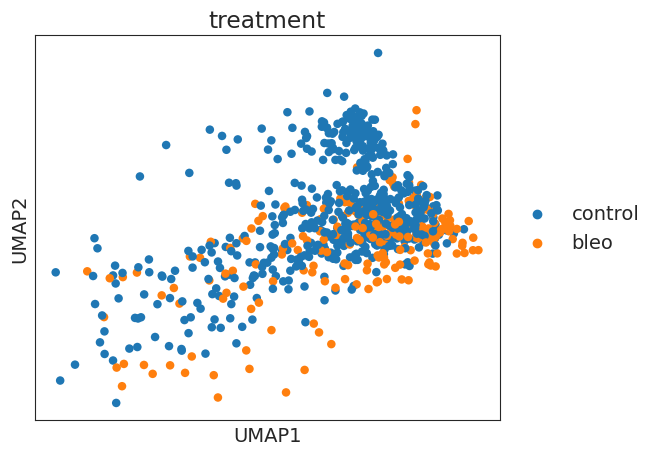

Started Diffxpy Calculation:	14-08-2024 17:00:28
training location model: True
training scale model: True
iter   0: ll=2356787.719439
iter   1: ll=2143190.381200, converged: 0.00% (loc: 0.27%, scale update: False), in 0.47sec
iter   2: ll=2091011.024787, converged: 0.00% (loc: 0.27%, scale update: False), in 0.50sec
iter   3: ll=2086934.336120, converged: 0.00% (loc: 0.27%, scale update: False), in 0.46sec
iter   4: ll=2086858.334115, converged: 0.00% (loc: 0.27%, scale update: False), in 0.63sec
iter   5: ll=2086857.387901, converged: 0.00% (loc: 0.46%, scale update: False), in 1.14sec
iter   6: ll=1931920.496826, converged: 0.00% (loc: 0.00%, scale update: True), in 6.49sec
iter   7: ll=1931272.479158, converged: 0.00% (loc: 0.04%, scale update: False), in 0.47sec
iter   8: ll=1931214.355375, converged: 0.00% (loc: 0.96%, scale update: False), in 0.46sec
iter   9: ll=1931211.330602, converged: 0.00% (loc: 7.94%, scale update: False), in 0.51sec
iter  10: ll=1931211.300538, converged:

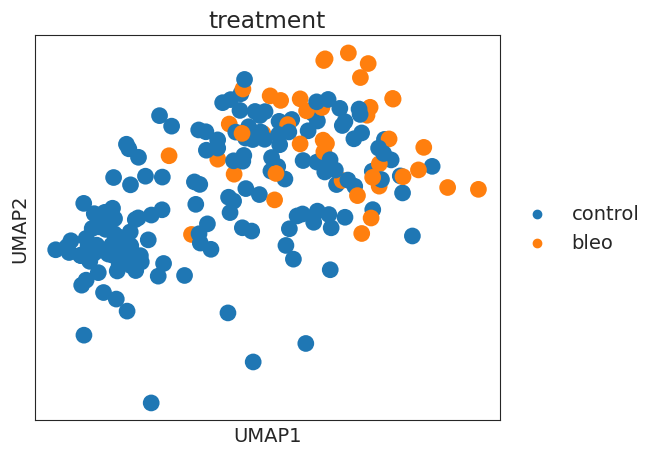

Started Diffxpy Calculation:	14-08-2024 17:01:20
training location model: True
training scale model: True
iter   0: ll=1250907.846365
caught 58 linalg singular matrix errors
iter   1: ll=1185220.970074, converged: 0.00% (loc: 4.83%, scale update: False), in 0.56sec
iter   2: ll=1169979.009595, converged: 0.00% (loc: 4.83%, scale update: False), in 0.64sec
iter   3: ll=1168775.982568, converged: 0.00% (loc: 4.83%, scale update: False), in 0.82sec
iter   4: ll=1168741.824411, converged: 0.00% (loc: 4.83%, scale update: False), in 0.60sec
iter   5: ll=1168740.633736, converged: 0.00% (loc: 5.35%, scale update: False), in 0.57sec
iter   6: ll=529473.623802, converged: 0.00% (loc: 0.00%, scale update: True), in 4.29sec
caught 58 linalg singular matrix errors
iter   7: ll=528450.333982, converged: 0.00% (loc: 1.91%, scale update: False), in 0.60sec
iter   8: ll=528320.073428, converged: 0.00% (loc: 3.40%, scale update: False), in 0.61sec
iter   9: ll=528311.272277, converged: 0.00% (loc: 12.

In [13]:
out_folder = "/media/HDD_1/Janine/Aging_SingleCell/data/DGE_data/dge_meta_label_young/"

subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d3"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_young")
    

### day 10

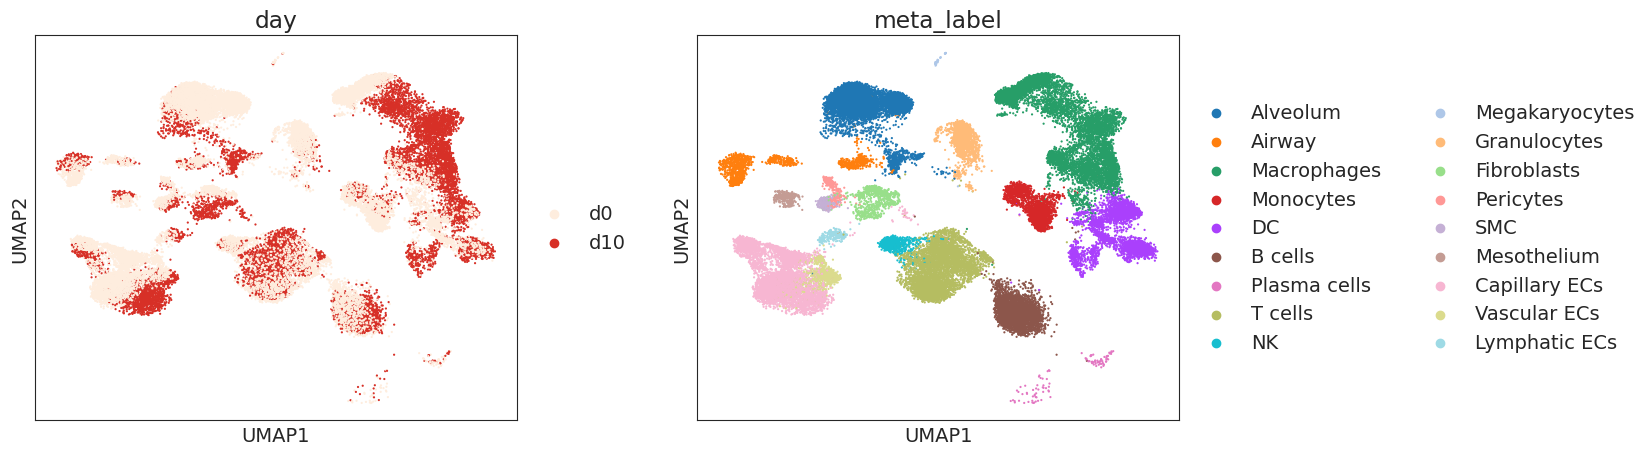

Alveolum - d10
(8229, 4474)


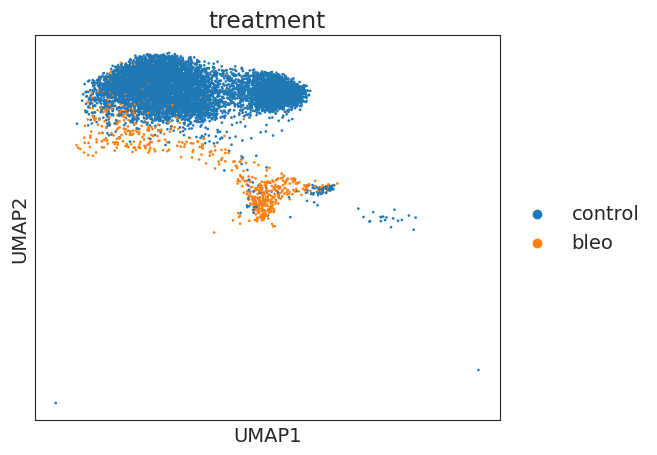

Started Diffxpy Calculation:	14-08-2024 17:02:22
training location model: True
training scale model: True
iter   0: ll=14600512.856992
iter   1: ll=13276138.722801, converged: 0.00% (loc: 0.00%, scale update: False), in 2.67sec
iter   2: ll=12980785.892424, converged: 0.00% (loc: 0.00%, scale update: False), in 2.75sec
iter   3: ll=12962911.205591, converged: 0.00% (loc: 0.00%, scale update: False), in 2.60sec
iter   4: ll=12962692.336523, converged: 0.00% (loc: 0.00%, scale update: False), in 2.64sec
iter   5: ll=12962688.609796, converged: 0.00% (loc: 1.97%, scale update: False), in 2.57sec
iter   6: ll=12722722.546567, converged: 0.00% (loc: 0.00%, scale update: True), in 35.80sec
iter   7: ll=12720768.547334, converged: 0.00% (loc: 0.00%, scale update: False), in 3.58sec
iter   8: ll=12720700.550865, converged: 0.00% (loc: 0.56%, scale update: False), in 3.64sec
iter   9: ll=12720697.726913, converged: 0.00% (loc: 3.93%, scale update: False), in 2.36sec
iter  10: ll=12720697.593708

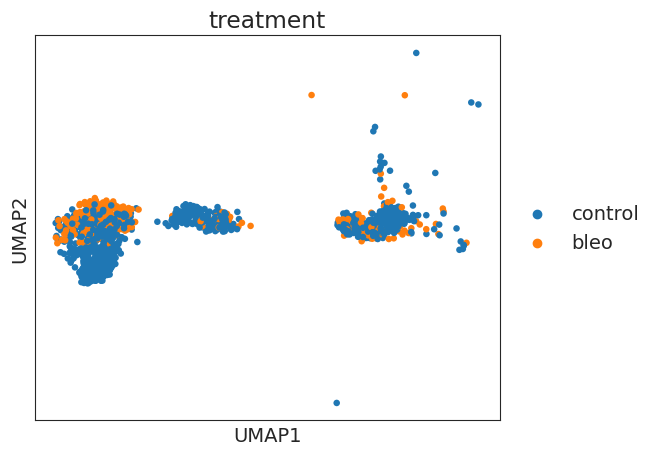

Started Diffxpy Calculation:	14-08-2024 17:05:53
training location model: True
training scale model: True
iter   0: ll=7114834.300248
caught 1 linalg singular matrix errors
iter   1: ll=6451811.994385, converged: 0.00% (loc: 1.29%, scale update: False), in 1.45sec
iter   2: ll=6246269.465684, converged: 0.00% (loc: 1.29%, scale update: False), in 1.14sec
iter   3: ll=6213431.021384, converged: 0.00% (loc: 1.29%, scale update: False), in 1.45sec
iter   4: ll=6210504.274170, converged: 0.00% (loc: 1.29%, scale update: False), in 1.53sec
iter   5: ll=6210291.452461, converged: 0.00% (loc: 1.32%, scale update: False), in 1.48sec
iter   6: ll=4413449.026919, converged: 0.00% (loc: 0.00%, scale update: True), in 10.85sec
caught 1 linalg singular matrix errors
iter   7: ll=4407782.197611, converged: 0.00% (loc: 0.02%, scale update: False), in 1.31sec
iter   8: ll=4407289.362489, converged: 0.00% (loc: 0.36%, scale update: False), in 1.34sec
iter   9: ll=4407247.230317, converged: 0.00% (loc: 

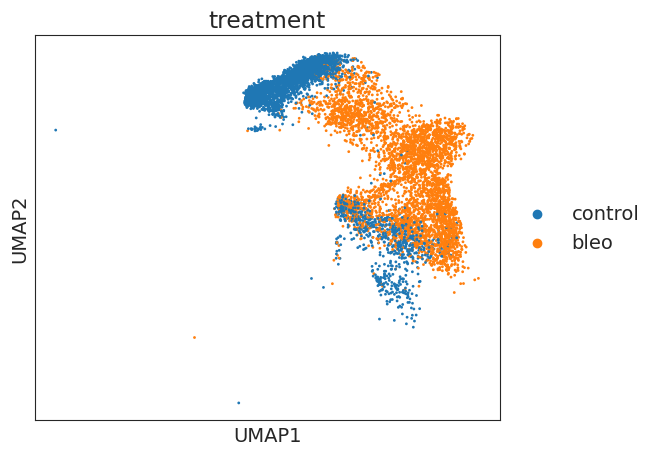

Started Diffxpy Calculation:	14-08-2024 17:07:37
training location model: True
training scale model: True
iter   0: ll=18812009.515480
iter   1: ll=17055733.484464, converged: 0.00% (loc: 0.00%, scale update: False), in 3.07sec
iter   2: ll=16624614.139919, converged: 0.00% (loc: 0.00%, scale update: False), in 2.53sec
iter   3: ll=16590766.398013, converged: 0.00% (loc: 0.00%, scale update: False), in 2.66sec
iter   4: ll=16590115.561863, converged: 0.00% (loc: 0.00%, scale update: False), in 2.54sec
iter   5: ll=16590107.300584, converged: 0.00% (loc: 0.17%, scale update: False), in 2.43sec
iter   6: ll=16387952.696630, converged: 0.00% (loc: 0.00%, scale update: True), in 36.22sec
iter   7: ll=16383926.526241, converged: 0.00% (loc: 0.02%, scale update: False), in 2.55sec
iter   8: ll=16383811.893400, converged: 0.00% (loc: 1.15%, scale update: False), in 2.45sec
iter   9: ll=16383808.939844, converged: 0.00% (loc: 4.50%, scale update: False), in 2.47sec
iter  10: ll=16383808.846290

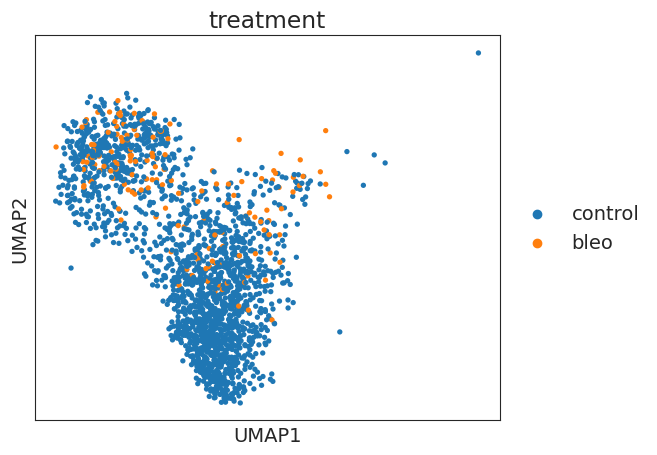

Started Diffxpy Calculation:	14-08-2024 17:11:36
training location model: True
training scale model: True
iter   0: ll=5404003.072950
caught 9 linalg singular matrix errors
iter   1: ll=4791997.036615, converged: 0.00% (loc: 0.25%, scale update: False), in 1.93sec
iter   2: ll=4652164.927530, converged: 0.00% (loc: 0.25%, scale update: False), in 1.91sec
iter   3: ll=4642755.194152, converged: 0.00% (loc: 0.25%, scale update: False), in 1.59sec
iter   4: ll=4642637.378534, converged: 0.00% (loc: 0.25%, scale update: False), in 1.75sec
iter   5: ll=4642636.766457, converged: 0.00% (loc: 0.80%, scale update: False), in 1.48sec
iter   6: ll=4571144.533328, converged: 0.00% (loc: 0.00%, scale update: True), in 14.51sec
caught 9 linalg singular matrix errors
iter   7: ll=4570810.946572, converged: 0.00% (loc: 0.30%, scale update: False), in 2.30sec
iter   8: ll=4570799.090056, converged: 0.00% (loc: 2.46%, scale update: False), in 2.17sec
iter   9: ll=4570798.709029, converged: 0.00% (loc: 

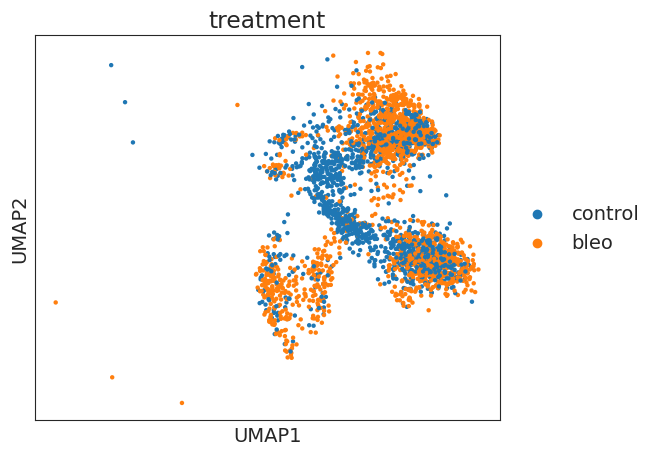

Started Diffxpy Calculation:	14-08-2024 17:13:07
training location model: True
training scale model: True
iter   0: ll=6529781.046463
iter   1: ll=5884121.159155, converged: 0.00% (loc: 0.00%, scale update: False), in 1.42sec
iter   2: ll=5738469.403255, converged: 0.00% (loc: 0.00%, scale update: False), in 1.39sec
iter   3: ll=5729762.268657, converged: 0.00% (loc: 0.00%, scale update: False), in 1.33sec
iter   4: ll=5729696.083236, converged: 0.00% (loc: 0.00%, scale update: False), in 1.95sec
iter   5: ll=5729695.941426, converged: 0.00% (loc: 1.46%, scale update: False), in 1.61sec
iter   6: ll=5659181.234796, converged: 0.00% (loc: 0.00%, scale update: True), in 14.17sec
iter   7: ll=5658611.653689, converged: 0.00% (loc: 0.05%, scale update: False), in 1.87sec
iter   8: ll=5658607.333642, converged: 0.00% (loc: 2.48%, scale update: False), in 1.54sec
iter   9: ll=5658607.308592, converged: 0.00% (loc: 15.50%, scale update: False), in 1.62sec
iter  10: ll=5658607.308429, converge

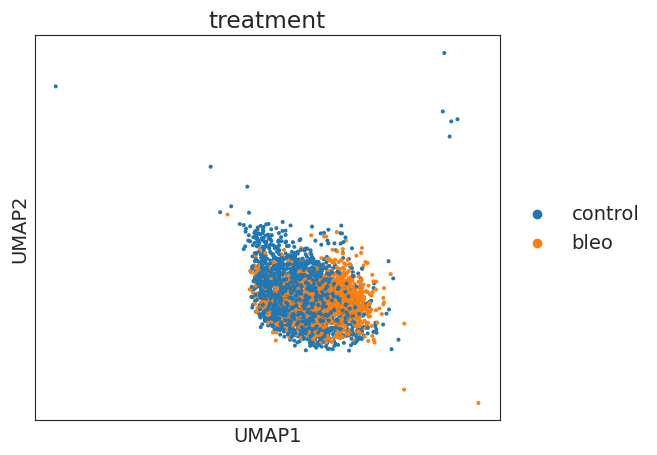

Started Diffxpy Calculation:	14-08-2024 17:14:50
training location model: True
training scale model: True
iter   0: ll=4649729.483951
iter   1: ll=4179196.874335, converged: 0.00% (loc: 0.00%, scale update: False), in 1.10sec
iter   2: ll=4068577.427089, converged: 0.00% (loc: 0.00%, scale update: False), in 1.05sec
iter   3: ll=4062526.938862, converged: 0.00% (loc: 0.00%, scale update: False), in 1.12sec
iter   4: ll=4062508.677195, converged: 0.00% (loc: 0.00%, scale update: False), in 1.07sec
iter   5: ll=4062508.675671, converged: 0.00% (loc: 35.65%, scale update: False), in 1.20sec
iter   6: ll=3979507.987004, converged: 0.00% (loc: 0.00%, scale update: True), in 11.22sec
iter   7: ll=3979465.619575, converged: 0.00% (loc: 0.04%, scale update: False), in 1.42sec
iter   8: ll=3979465.591960, converged: 0.00% (loc: 21.41%, scale update: False), in 1.15sec
iter   9: ll=3979465.591943, converged: 0.00% (loc: 98.81%, scale update: False), in 1.01sec
iter  10: ll=3979465.591943, conver

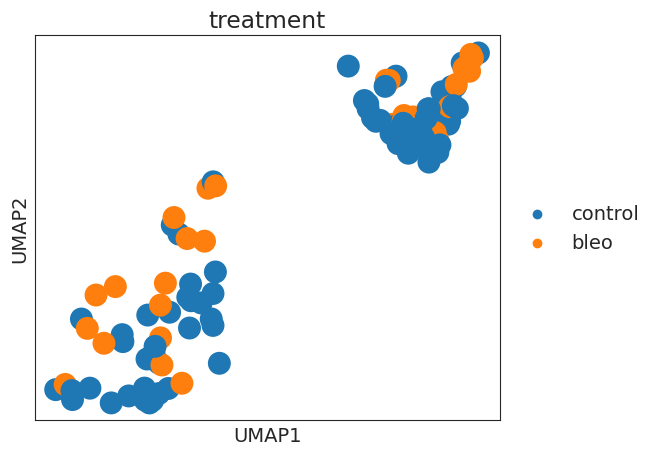

Started Diffxpy Calculation:	14-08-2024 17:15:45
training location model: True
training scale model: True
iter   0: ll=743167.565561
caught 135 linalg singular matrix errors
iter   1: ll=724285.645048, converged: 0.00% (loc: 15.47%, scale update: False), in 0.19sec
iter   2: ll=718393.805903, converged: 0.00% (loc: 15.47%, scale update: False), in 0.19sec
iter   3: ll=717418.824357, converged: 0.00% (loc: 15.47%, scale update: False), in 0.19sec
iter   4: ll=717318.305326, converged: 0.00% (loc: 15.47%, scale update: False), in 0.20sec
iter   5: ll=717308.558656, converged: 0.00% (loc: 15.71%, scale update: False), in 0.19sec
iter   6: ll=152560.004354, converged: 0.00% (loc: 0.00%, scale update: True), in 1.63sec
caught 133 linalg singular matrix errors
iter   7: ll=151321.157420, converged: 0.00% (loc: 7.21%, scale update: False), in 0.23sec
iter   8: ll=151142.099621, converged: 0.00% (loc: 8.65%, scale update: False), in 0.22sec
iter   9: ll=151122.054281, converged: 0.00% (loc: 11

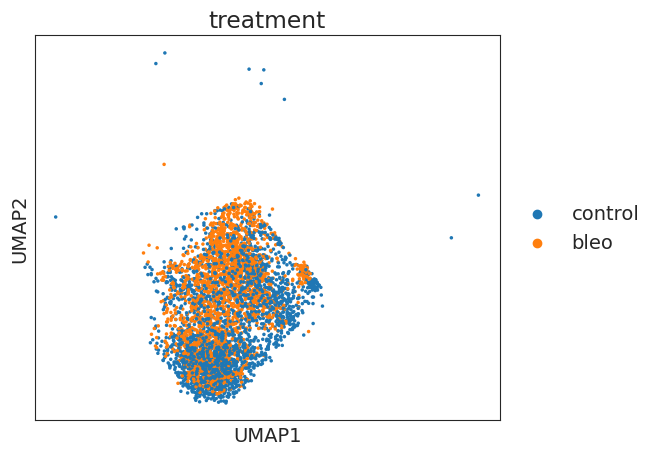

Started Diffxpy Calculation:	14-08-2024 17:16:17
training location model: True
training scale model: True
iter   0: ll=7012705.100801
iter   1: ll=6343860.796047, converged: 0.00% (loc: 0.00%, scale update: False), in 1.44sec
iter   2: ll=6190776.861692, converged: 0.00% (loc: 0.00%, scale update: False), in 1.50sec
iter   3: ll=6182634.459035, converged: 0.00% (loc: 0.00%, scale update: False), in 1.55sec
iter   4: ll=6182606.726206, converged: 0.00% (loc: 0.00%, scale update: False), in 1.33sec
iter   5: ll=6182606.721163, converged: 0.00% (loc: 26.17%, scale update: False), in 1.36sec
iter   6: ll=6065442.419800, converged: 0.00% (loc: 0.00%, scale update: True), in 20.92sec
iter   7: ll=6065335.443625, converged: 0.00% (loc: 0.14%, scale update: False), in 1.62sec
iter   8: ll=6065335.095991, converged: 0.00% (loc: 12.51%, scale update: False), in 1.65sec
iter   9: ll=6065335.094742, converged: 0.00% (loc: 88.70%, scale update: False), in 1.22sec
iter  10: ll=6065335.094733, conver

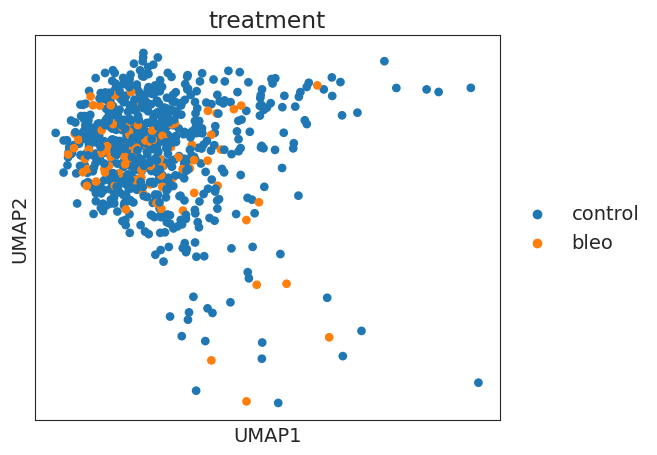

Started Diffxpy Calculation:	14-08-2024 17:17:43
training location model: True
training scale model: True
iter   0: ll=1130303.433167
caught 17 linalg singular matrix errors
iter   1: ll=1023366.604721, converged: 0.00% (loc: 0.60%, scale update: False), in 0.90sec
iter   2: ll=999410.258127, converged: 0.00% (loc: 0.60%, scale update: False), in 0.66sec
iter   3: ll=998162.135569, converged: 0.00% (loc: 0.60%, scale update: False), in 0.59sec
iter   4: ll=998157.399815, converged: 0.00% (loc: 0.60%, scale update: False), in 0.33sec
iter   5: ll=998157.396660, converged: 0.00% (loc: 24.43%, scale update: False), in 0.35sec
iter   6: ll=979873.568706, converged: 0.00% (loc: 0.00%, scale update: True), in 4.76sec
caught 17 linalg singular matrix errors
iter   7: ll=979850.935562, converged: 0.00% (loc: 0.71%, scale update: False), in 0.62sec
iter   8: ll=979850.840689, converged: 0.00% (loc: 13.37%, scale update: False), in 0.70sec
iter   9: ll=979850.840239, converged: 0.00% (loc: 86.77

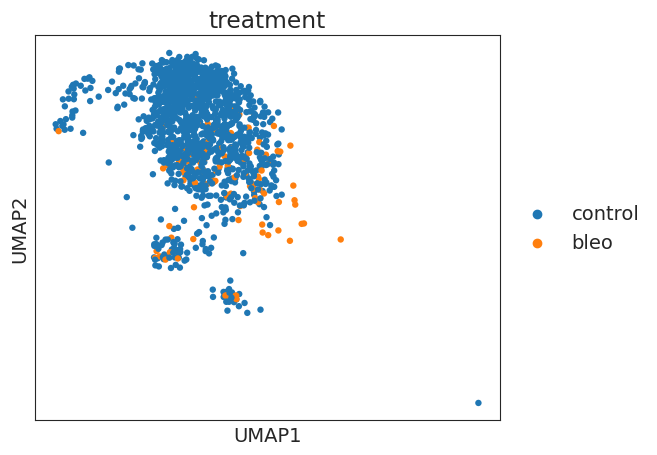

Started Diffxpy Calculation:	14-08-2024 17:18:10
training location model: True
training scale model: True
iter   0: ll=1548599.023874
caught 7 linalg singular matrix errors
iter   1: ll=1387127.477718, converged: 0.00% (loc: 0.39%, scale update: False), in 0.86sec
iter   2: ll=1347559.082308, converged: 0.00% (loc: 0.39%, scale update: False), in 0.76sec
iter   3: ll=1345164.136144, converged: 0.00% (loc: 0.39%, scale update: False), in 0.79sec
iter   4: ll=1345152.170160, converged: 0.00% (loc: 0.39%, scale update: False), in 0.56sec
iter   5: ll=1345152.164823, converged: 0.00% (loc: 15.12%, scale update: False), in 0.65sec
iter   6: ll=1321036.678120, converged: 0.00% (loc: 0.00%, scale update: True), in 4.31sec
caught 7 linalg singular matrix errors
iter   7: ll=1321022.392852, converged: 0.00% (loc: 0.39%, scale update: False), in 0.67sec
iter   8: ll=1321022.363898, converged: 0.00% (loc: 20.03%, scale update: False), in 0.73sec
iter   9: ll=1321022.363788, converged: 0.00% (loc:

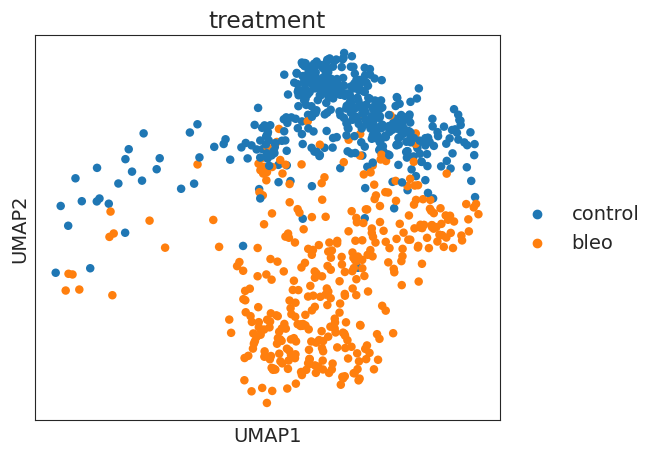

Started Diffxpy Calculation:	14-08-2024 17:18:35
training location model: True
training scale model: True
iter   0: ll=2327686.685991
caught 19 linalg singular matrix errors
iter   1: ll=2126709.640182, converged: 0.00% (loc: 0.44%, scale update: False), in 0.47sec
iter   2: ll=2073740.173498, converged: 0.00% (loc: 0.44%, scale update: False), in 0.80sec
iter   3: ll=2068549.223493, converged: 0.00% (loc: 0.44%, scale update: False), in 1.76sec
iter   4: ll=2068369.905078, converged: 0.00% (loc: 0.44%, scale update: False), in 1.40sec
iter   5: ll=2068364.717012, converged: 0.00% (loc: 0.49%, scale update: False), in 1.29sec
iter   6: ll=1951949.550453, converged: 0.00% (loc: 0.00%, scale update: True), in 9.42sec
caught 19 linalg singular matrix errors
iter   7: ll=1951297.872167, converged: 0.00% (loc: 0.37%, scale update: False), in 0.52sec
iter   8: ll=1951261.055274, converged: 0.00% (loc: 1.19%, scale update: False), in 0.50sec
iter   9: ll=1951259.175757, converged: 0.00% (loc:

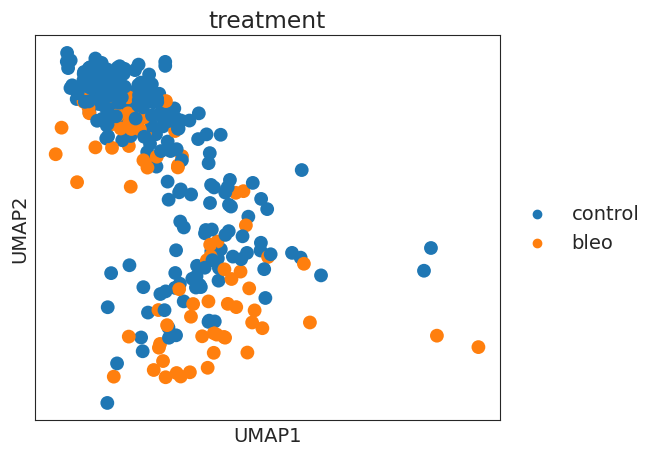

Started Diffxpy Calculation:	14-08-2024 17:19:49
training location model: True
training scale model: True
iter   0: ll=711365.867739
caught 26 linalg singular matrix errors
iter   1: ll=650789.794358, converged: 0.00% (loc: 0.76%, scale update: False), in 0.63sec
iter   2: ll=637260.724579, converged: 0.00% (loc: 0.76%, scale update: False), in 0.49sec
iter   3: ll=636451.526611, converged: 0.00% (loc: 0.76%, scale update: False), in 0.52sec
iter   4: ll=636441.999425, converged: 0.00% (loc: 0.76%, scale update: False), in 0.49sec
iter   5: ll=636441.848702, converged: 0.00% (loc: 9.39%, scale update: False), in 0.50sec
iter   6: ll=599717.843541, converged: 0.00% (loc: 0.00%, scale update: True), in 4.26sec
caught 26 linalg singular matrix errors
iter   7: ll=599572.416363, converged: 0.00% (loc: 0.54%, scale update: False), in 0.89sec
iter   8: ll=599556.499612, converged: 0.00% (loc: 3.25%, scale update: False), in 0.90sec
iter   9: ll=599553.115516, converged: 0.00% (loc: 29.11%, s

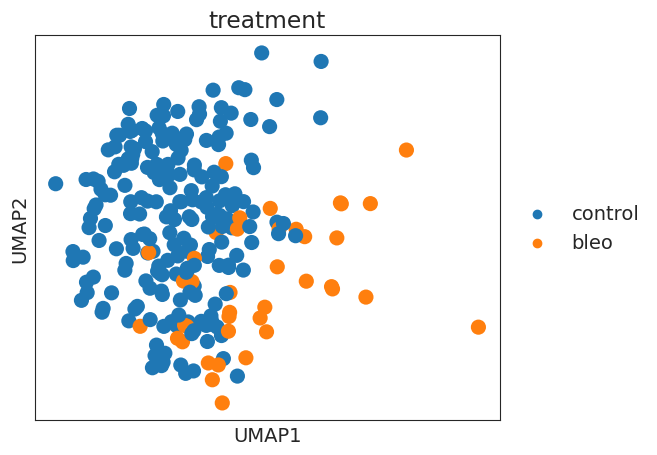

Started Diffxpy Calculation:	14-08-2024 17:20:36
training location model: True
training scale model: True
iter   0: ll=845439.574298
caught 106 linalg singular matrix errors
iter   1: ll=779626.040620, converged: 0.00% (loc: 3.96%, scale update: False), in 0.39sec
iter   2: ll=764080.511611, converged: 0.00% (loc: 3.96%, scale update: False), in 0.42sec
iter   3: ll=762913.231312, converged: 0.00% (loc: 3.96%, scale update: False), in 0.43sec
iter   4: ll=762891.262991, converged: 0.00% (loc: 3.96%, scale update: False), in 0.59sec
iter   5: ll=762890.950746, converged: 0.00% (loc: 4.48%, scale update: False), in 0.42sec
iter   6: ll=541837.554013, converged: 0.00% (loc: 0.00%, scale update: True), in 4.71sec
caught 106 linalg singular matrix errors
iter   7: ll=541367.774823, converged: 0.00% (loc: 2.64%, scale update: False), in 1.02sec
iter   8: ll=541335.034205, converged: 0.00% (loc: 5.24%, scale update: False), in 0.78sec
iter   9: ll=541333.802572, converged: 0.00% (loc: 16.46%,

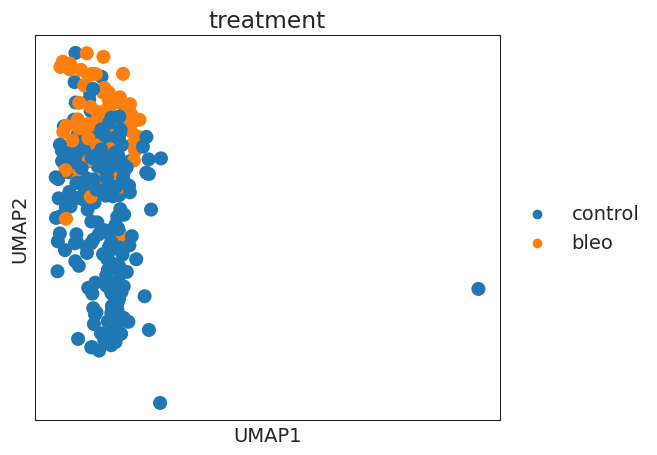

Started Diffxpy Calculation:	14-08-2024 17:21:42
training location model: True
training scale model: True
iter   0: ll=883754.560240
caught 26 linalg singular matrix errors
iter   1: ll=803941.116327, converged: 0.00% (loc: 1.31%, scale update: False), in 0.75sec
iter   2: ll=784347.915259, converged: 0.00% (loc: 1.31%, scale update: False), in 0.90sec
iter   3: ll=782668.304203, converged: 0.00% (loc: 1.31%, scale update: False), in 1.52sec
iter   4: ll=782622.073170, converged: 0.00% (loc: 1.31%, scale update: False), in 0.61sec
iter   5: ll=782620.911161, converged: 0.00% (loc: 1.46%, scale update: False), in 0.57sec
iter   6: ll=653000.319115, converged: 0.00% (loc: 0.00%, scale update: True), in 4.36sec
caught 26 linalg singular matrix errors
iter   7: ll=652554.102536, converged: 0.00% (loc: 0.66%, scale update: False), in 0.51sec
iter   8: ll=652498.667384, converged: 0.00% (loc: 1.54%, scale update: False), in 0.45sec
iter   9: ll=652497.571874, converged: 0.00% (loc: 8.27%, sc

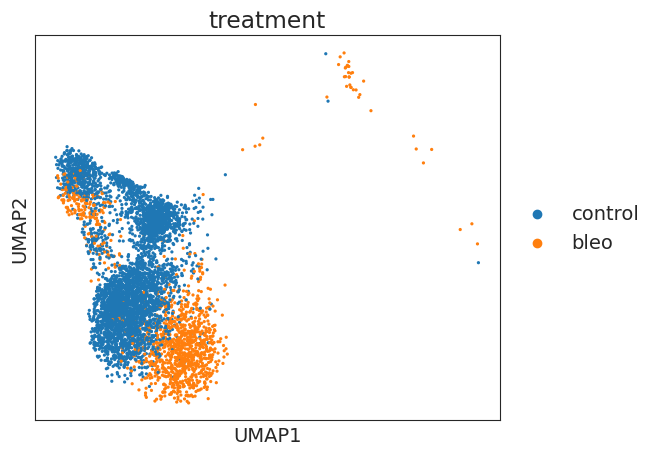

Started Diffxpy Calculation:	14-08-2024 17:22:44
training location model: True
training scale model: True
iter   0: ll=11200578.244170
iter   1: ll=10240921.438983, converged: 0.00% (loc: 0.00%, scale update: False), in 2.54sec
iter   2: ll=10020524.112429, converged: 0.00% (loc: 0.00%, scale update: False), in 2.65sec
iter   3: ll=10008262.822826, converged: 0.00% (loc: 0.00%, scale update: False), in 2.00sec
iter   4: ll=10008208.906119, converged: 0.00% (loc: 0.00%, scale update: False), in 2.56sec
iter   5: ll=10008208.884320, converged: 0.00% (loc: 9.75%, scale update: False), in 2.70sec
iter   6: ll=9759541.902686, converged: 0.00% (loc: 0.00%, scale update: True), in 23.37sec
iter   7: ll=9758967.029592, converged: 0.00% (loc: 0.03%, scale update: False), in 2.81sec
iter   8: ll=9758964.226309, converged: 0.00% (loc: 2.30%, scale update: False), in 2.64sec
iter   9: ll=9758964.213934, converged: 0.00% (loc: 31.75%, scale update: False), in 1.83sec
iter  10: ll=9758964.213854, co

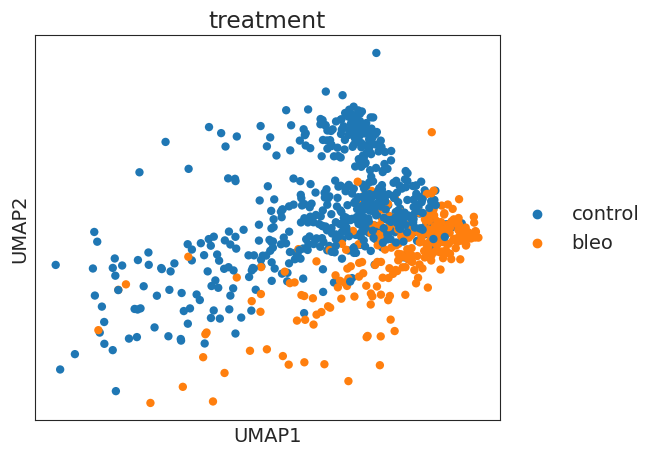

Started Diffxpy Calculation:	14-08-2024 17:24:57
training location model: True
training scale model: True
iter   0: ll=2082217.706218
caught 3 linalg singular matrix errors
iter   1: ll=1891434.919850, converged: 0.00% (loc: 0.09%, scale update: False), in 1.00sec
iter   2: ll=1845976.323125, converged: 0.00% (loc: 0.09%, scale update: False), in 0.62sec
iter   3: ll=1842794.460959, converged: 0.00% (loc: 0.09%, scale update: False), in 0.48sec
iter   4: ll=1842754.415664, converged: 0.00% (loc: 0.09%, scale update: False), in 1.18sec
iter   5: ll=1842754.180645, converged: 0.00% (loc: 0.72%, scale update: False), in 0.77sec
iter   6: ll=1803543.771244, converged: 0.00% (loc: 0.00%, scale update: True), in 6.32sec
caught 3 linalg singular matrix errors
iter   7: ll=1803097.450038, converged: 0.00% (loc: 0.09%, scale update: False), in 0.61sec
iter   8: ll=1803068.348587, converged: 0.00% (loc: 1.82%, scale update: False), in 0.43sec
iter   9: ll=1803068.237264, converged: 0.00% (loc: 9

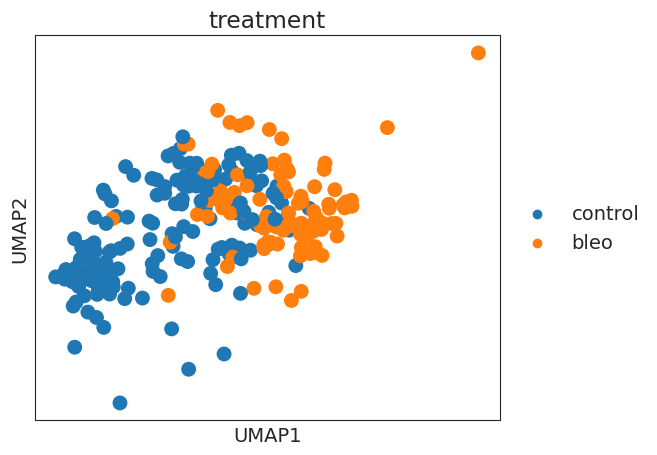

Started Diffxpy Calculation:	14-08-2024 17:25:44
training location model: True
training scale model: True
iter   0: ll=1408323.402927
caught 82 linalg singular matrix errors
iter   1: ll=1324494.339236, converged: 0.00% (loc: 3.91%, scale update: False), in 0.68sec
iter   2: ll=1302620.154299, converged: 0.00% (loc: 3.91%, scale update: False), in 0.66sec
iter   3: ll=1300244.999449, converged: 0.00% (loc: 3.91%, scale update: False), in 0.67sec
iter   4: ll=1300110.106973, converged: 0.00% (loc: 3.91%, scale update: False), in 0.61sec
iter   5: ll=1300101.848115, converged: 0.00% (loc: 4.01%, scale update: False), in 0.51sec
iter   6: ll=740328.034896, converged: 0.02% (loc: 0.02%, scale update: True), in 4.83sec
caught 80 linalg singular matrix errors
iter   7: ll=738816.271290, converged: 0.02% (loc: 1.91%, scale update: False), in 0.50sec
iter   8: ll=738541.565912, converged: 0.02% (loc: 2.53%, scale update: False), in 0.47sec
iter   9: ll=738507.487952, converged: 0.02% (loc: 6.3

In [14]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d10"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_young")
    
    

 ## day 20

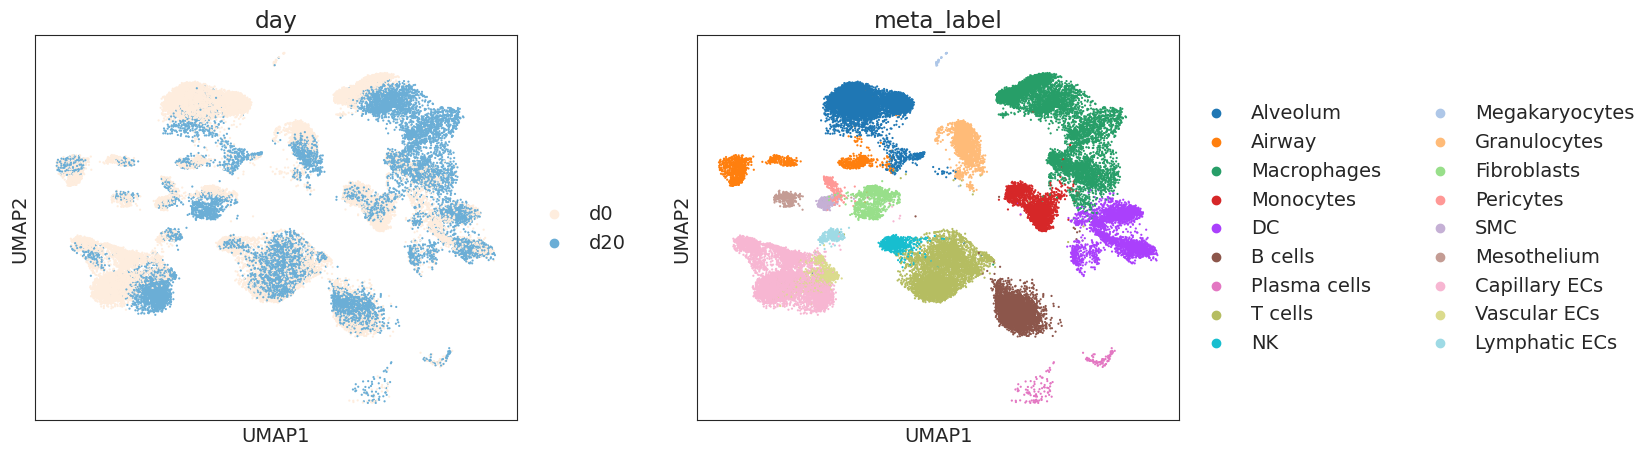

Alveolum - d20
(8094, 4509)


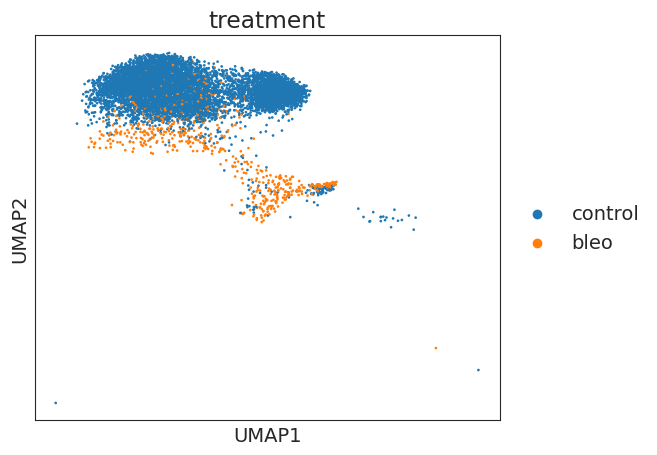

Started Diffxpy Calculation:	14-08-2024 18:07:11
training location model: True
training scale model: True
iter   0: ll=14562945.361437
iter   1: ll=13219348.684666, converged: 0.00% (loc: 0.00%, scale update: False), in 2.69sec
iter   2: ll=12921940.200841, converged: 0.00% (loc: 0.00%, scale update: False), in 2.88sec
iter   3: ll=12904263.022484, converged: 0.00% (loc: 0.00%, scale update: False), in 2.63sec
iter   4: ll=12904065.854762, converged: 0.00% (loc: 0.00%, scale update: False), in 2.74sec
iter   5: ll=12904063.204569, converged: 0.00% (loc: 0.62%, scale update: False), in 2.55sec
iter   6: ll=12690420.679866, converged: 0.00% (loc: 0.00%, scale update: True), in 39.69sec
iter   7: ll=12688434.903734, converged: 0.00% (loc: 0.00%, scale update: False), in 2.76sec
iter   8: ll=12688357.548717, converged: 0.00% (loc: 0.60%, scale update: False), in 3.25sec
iter   9: ll=12688354.121788, converged: 0.00% (loc: 3.17%, scale update: False), in 3.91sec
iter  10: ll=12688353.953932

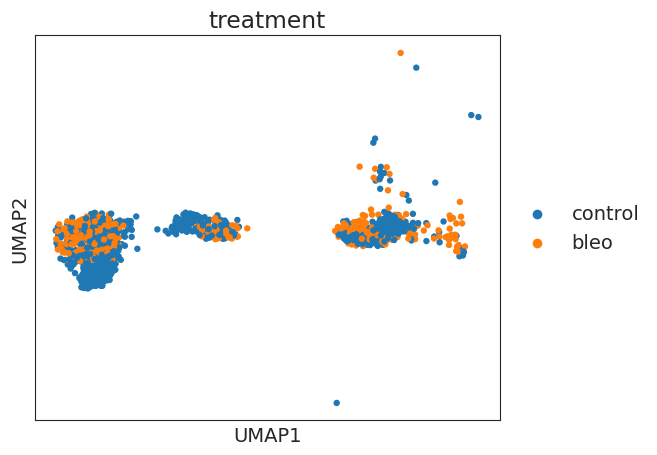

Started Diffxpy Calculation:	14-08-2024 18:11:17
training location model: True
training scale model: True
iter   0: ll=9306870.218529
iter   1: ll=8551009.920238, converged: 0.00% (loc: 2.15%, scale update: False), in 1.88sec
iter   2: ll=8304760.058290, converged: 0.00% (loc: 2.15%, scale update: False), in 1.44sec
iter   3: ll=8259385.434337, converged: 0.00% (loc: 2.15%, scale update: False), in 1.31sec
iter   4: ll=8253992.807463, converged: 0.00% (loc: 2.15%, scale update: False), in 1.51sec
iter   5: ll=8253450.150002, converged: 0.00% (loc: 2.18%, scale update: False), in 1.52sec
iter   6: ll=4693543.766149, converged: 0.00% (loc: 0.00%, scale update: True), in 12.59sec
iter   7: ll=4682235.690057, converged: 0.00% (loc: 0.02%, scale update: False), in 2.77sec
iter   8: ll=4680981.540781, converged: 0.00% (loc: 0.33%, scale update: False), in 2.39sec
iter   9: ll=4680887.323120, converged: 0.00% (loc: 1.36%, scale update: False), in 2.99sec
iter  10: ll=4680883.234730, converged

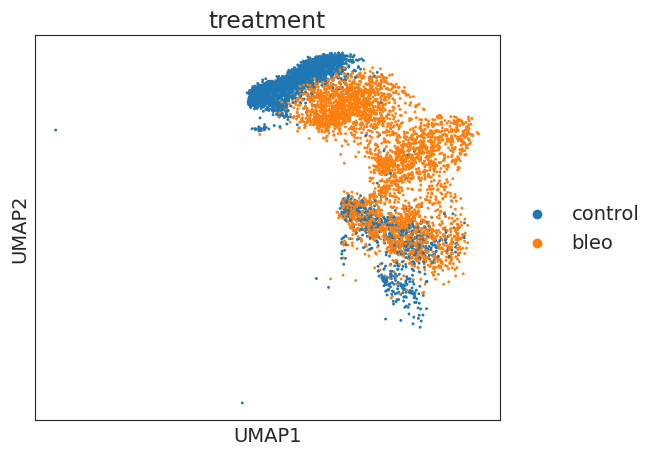

Started Diffxpy Calculation:	14-08-2024 18:13:20
training location model: True
training scale model: True
iter   0: ll=17665739.744934
iter   1: ll=15992301.664876, converged: 0.00% (loc: 0.00%, scale update: False), in 3.44sec
iter   2: ll=15589730.034481, converged: 0.00% (loc: 0.00%, scale update: False), in 3.27sec
iter   3: ll=15559121.749464, converged: 0.00% (loc: 0.00%, scale update: False), in 2.63sec
iter   4: ll=15558539.843411, converged: 0.00% (loc: 0.00%, scale update: False), in 2.87sec
iter   5: ll=15558532.567574, converged: 0.00% (loc: 0.22%, scale update: False), in 2.46sec
iter   6: ll=15431221.669811, converged: 0.00% (loc: 0.00%, scale update: True), in 41.05sec
iter   7: ll=15428819.482461, converged: 0.00% (loc: 0.02%, scale update: False), in 2.48sec
iter   8: ll=15428751.007079, converged: 0.00% (loc: 1.44%, scale update: False), in 2.51sec
iter   9: ll=15428748.929306, converged: 0.00% (loc: 6.51%, scale update: False), in 2.40sec
iter  10: ll=15428748.837806

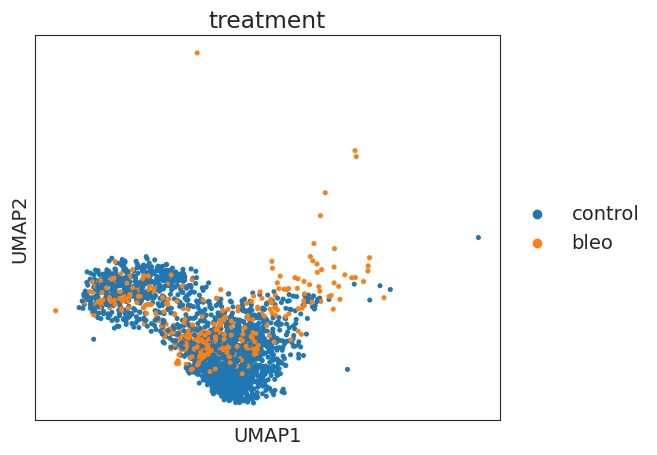

Started Diffxpy Calculation:	14-08-2024 18:17:30
training location model: True
training scale model: True
iter   0: ll=5665139.336532
iter   1: ll=5050323.843190, converged: 0.00% (loc: 0.00%, scale update: False), in 1.98sec
iter   2: ll=4910662.251061, converged: 0.00% (loc: 0.00%, scale update: False), in 1.31sec
iter   3: ll=4901671.343039, converged: 0.00% (loc: 0.00%, scale update: False), in 1.25sec
iter   4: ll=4901573.026648, converged: 0.00% (loc: 0.00%, scale update: False), in 1.38sec
iter   5: ll=4901572.603654, converged: 0.00% (loc: 0.82%, scale update: False), in 1.35sec
iter   6: ll=4870136.776836, converged: 0.00% (loc: 0.00%, scale update: True), in 14.50sec
iter   7: ll=4869724.739005, converged: 0.00% (loc: 0.05%, scale update: False), in 1.87sec
iter   8: ll=4869720.721010, converged: 0.00% (loc: 1.56%, scale update: False), in 2.59sec
iter   9: ll=4869720.689211, converged: 0.00% (loc: 13.49%, scale update: False), in 2.12sec
iter  10: ll=4869720.688921, converge

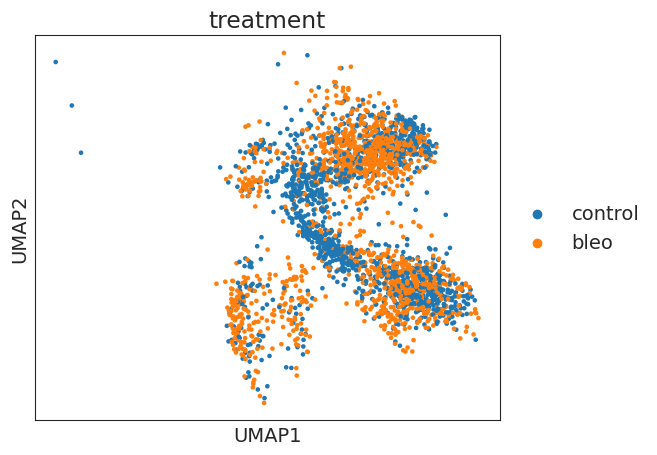

Started Diffxpy Calculation:	14-08-2024 18:19:00
training location model: True
training scale model: True
iter   0: ll=5841630.353772
iter   1: ll=5260774.345854, converged: 0.00% (loc: 0.00%, scale update: False), in 1.17sec
iter   2: ll=5134017.033554, converged: 0.00% (loc: 0.00%, scale update: False), in 1.35sec
iter   3: ll=5126933.987791, converged: 0.00% (loc: 0.00%, scale update: False), in 1.29sec
iter   4: ll=5126887.189343, converged: 0.00% (loc: 0.00%, scale update: False), in 1.42sec
iter   5: ll=5126887.107953, converged: 0.00% (loc: 2.48%, scale update: False), in 1.38sec
iter   6: ll=5076011.598534, converged: 0.00% (loc: 0.00%, scale update: True), in 16.21sec
iter   7: ll=5075664.130264, converged: 0.00% (loc: 0.08%, scale update: False), in 1.52sec
iter   8: ll=5075661.982093, converged: 0.00% (loc: 3.22%, scale update: False), in 1.48sec
iter   9: ll=5075661.971764, converged: 0.00% (loc: 21.30%, scale update: False), in 1.45sec
iter  10: ll=5075661.971709, converge

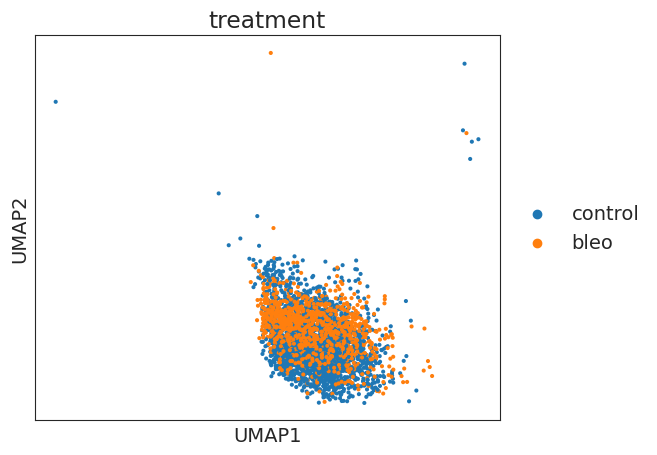

Started Diffxpy Calculation:	14-08-2024 18:20:29
training location model: True
training scale model: True
iter   0: ll=4348167.996959
iter   1: ll=3916755.285723, converged: 0.00% (loc: 0.00%, scale update: False), in 0.94sec
iter   2: ll=3811296.773144, converged: 0.00% (loc: 0.00%, scale update: False), in 1.04sec
iter   3: ll=3804996.276230, converged: 0.00% (loc: 0.00%, scale update: False), in 1.15sec
iter   4: ll=3804970.514681, converged: 0.00% (loc: 0.00%, scale update: False), in 1.31sec
iter   5: ll=3804970.511342, converged: 0.00% (loc: 24.04%, scale update: False), in 1.46sec
iter   6: ll=3722103.369187, converged: 0.00% (loc: 0.00%, scale update: True), in 11.40sec
iter   7: ll=3722064.151476, converged: 0.00% (loc: 0.00%, scale update: False), in 0.88sec
iter   8: ll=3722064.113834, converged: 0.00% (loc: 21.93%, scale update: False), in 1.04sec
iter   9: ll=3722064.113786, converged: 0.00% (loc: 97.72%, scale update: False), in 1.04sec
iter  10: ll=3722064.113786, conver

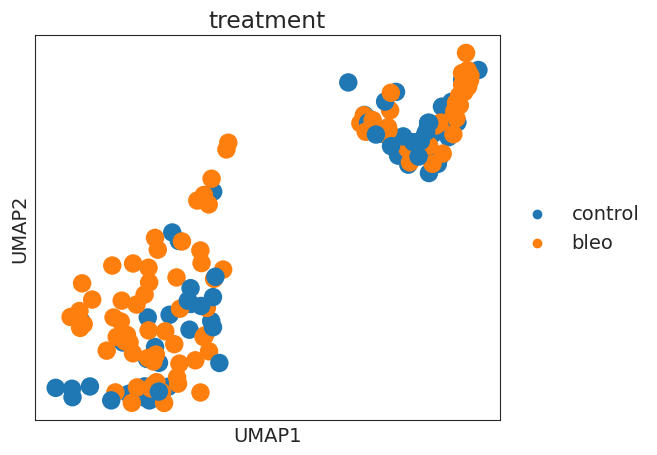

Started Diffxpy Calculation:	14-08-2024 18:21:22
training location model: True
training scale model: True
iter   0: ll=1288096.801972
caught 57 linalg singular matrix errors
iter   1: ll=1257633.676504, converged: 0.00% (loc: 13.46%, scale update: False), in 0.73sec
iter   2: ll=1248921.239375, converged: 0.00% (loc: 13.46%, scale update: False), in 0.28sec
iter   3: ll=1247702.357080, converged: 0.00% (loc: 13.46%, scale update: False), in 0.28sec
iter   4: ll=1247603.667235, converged: 0.00% (loc: 13.46%, scale update: False), in 0.64sec
iter   5: ll=1247596.482864, converged: 0.00% (loc: 13.74%, scale update: False), in 0.37sec
iter   6: ll=253078.117094, converged: 0.00% (loc: 0.00%, scale update: True), in 3.08sec
caught 56 linalg singular matrix errors
iter   7: ll=249966.028805, converged: 0.00% (loc: 3.52%, scale update: False), in 0.38sec
iter   8: ll=249226.894907, converged: 0.00% (loc: 4.83%, scale update: False), in 0.34sec
iter   9: ll=249153.705319, converged: 0.00% (loc

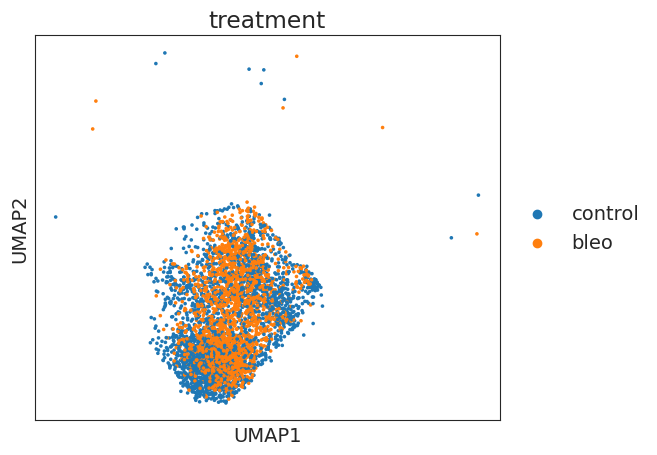

Started Diffxpy Calculation:	14-08-2024 18:22:05
training location model: True
training scale model: True
iter   0: ll=5965567.534546
iter   1: ll=5389986.297215, converged: 0.00% (loc: 0.00%, scale update: False), in 1.83sec
iter   2: ll=5254154.410650, converged: 0.00% (loc: 0.00%, scale update: False), in 1.70sec
iter   3: ll=5246620.005515, converged: 0.00% (loc: 0.00%, scale update: False), in 1.87sec
iter   4: ll=5246594.892538, converged: 0.00% (loc: 0.00%, scale update: False), in 1.75sec
iter   5: ll=5246594.890436, converged: 0.00% (loc: 25.50%, scale update: False), in 1.79sec
iter   6: ll=5141203.479003, converged: 0.00% (loc: 0.00%, scale update: True), in 20.57sec
iter   7: ll=5141142.007424, converged: 0.00% (loc: 0.00%, scale update: False), in 1.84sec
iter   8: ll=5141141.929620, converged: 0.00% (loc: 17.08%, scale update: False), in 1.94sec
iter   9: ll=5141141.929519, converged: 0.00% (loc: 97.34%, scale update: False), in 1.64sec
iter  10: ll=5141141.929518, conver

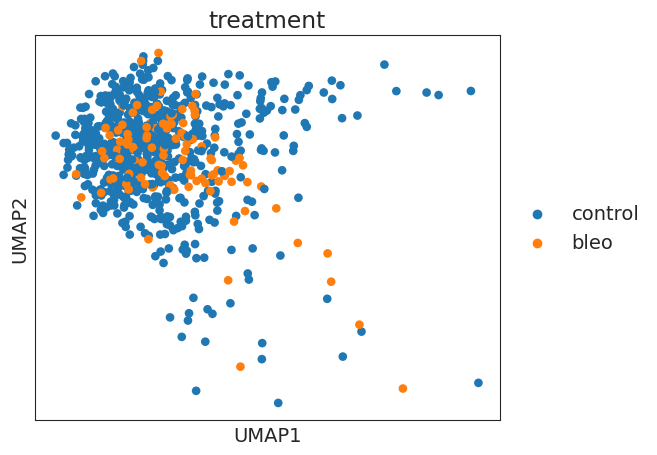

Started Diffxpy Calculation:	14-08-2024 18:23:33
training location model: True
training scale model: True
iter   0: ll=1095712.902686
caught 18 linalg singular matrix errors
iter   1: ll=992812.704293, converged: 0.00% (loc: 0.69%, scale update: False), in 0.28sec
iter   2: ll=969045.840011, converged: 0.00% (loc: 0.69%, scale update: False), in 0.27sec
iter   3: ll=967702.429799, converged: 0.00% (loc: 0.69%, scale update: False), in 0.29sec
iter   4: ll=967695.243499, converged: 0.00% (loc: 0.69%, scale update: False), in 0.47sec
iter   5: ll=967695.236268, converged: 0.00% (loc: 20.78%, scale update: False), in 0.27sec
iter   6: ll=948319.682281, converged: 0.00% (loc: 0.00%, scale update: True), in 3.83sec
caught 18 linalg singular matrix errors
iter   7: ll=948301.600571, converged: 0.00% (loc: 0.73%, scale update: False), in 0.29sec
iter   8: ll=948301.572496, converged: 0.00% (loc: 17.44%, scale update: False), in 0.42sec
iter   9: ll=948301.572460, converged: 0.00% (loc: 94.12%

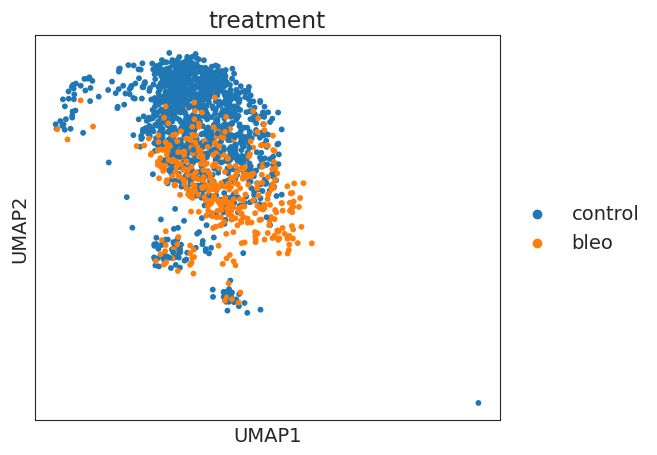

Started Diffxpy Calculation:	14-08-2024 18:23:57
training location model: True
training scale model: True
iter   0: ll=1707200.267752
iter   1: ll=1529940.146664, converged: 0.00% (loc: 0.00%, scale update: False), in 0.62sec
iter   2: ll=1482150.713743, converged: 0.00% (loc: 0.00%, scale update: False), in 0.69sec
iter   3: ll=1478462.943334, converged: 0.00% (loc: 0.00%, scale update: False), in 0.68sec
iter   4: ll=1478427.844013, converged: 0.00% (loc: 0.00%, scale update: False), in 0.66sec
iter   5: ll=1478427.834404, converged: 0.00% (loc: 5.87%, scale update: False), in 0.71sec
iter   6: ll=1443951.162872, converged: 0.00% (loc: 0.00%, scale update: True), in 4.28sec
iter   7: ll=1443935.800911, converged: 0.00% (loc: 0.00%, scale update: False), in 0.66sec
iter   8: ll=1443935.786631, converged: 0.00% (loc: 25.09%, scale update: False), in 0.80sec
iter   9: ll=1443935.786617, converged: 0.00% (loc: 97.16%, scale update: False), in 0.70sec
iter  10: ll=1443935.786617, converge

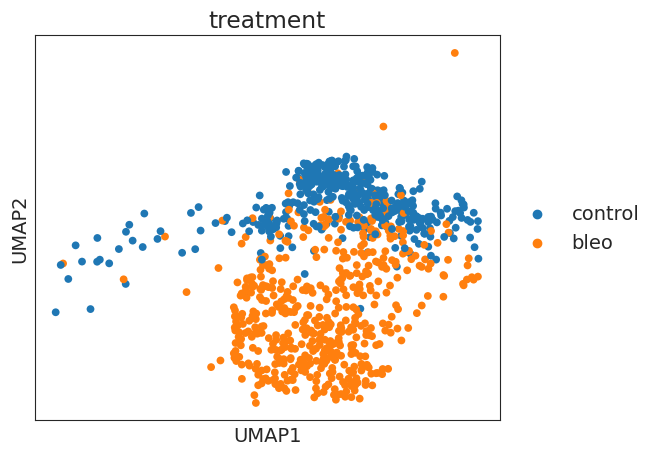

Started Diffxpy Calculation:	14-08-2024 18:24:23
training location model: True
training scale model: True
iter   0: ll=3475841.199160
caught 29 linalg singular matrix errors
iter   1: ll=3218973.747219, converged: 0.00% (loc: 1.03%, scale update: False), in 0.50sec
iter   2: ll=3141473.231032, converged: 0.00% (loc: 1.03%, scale update: False), in 0.50sec
iter   3: ll=3130766.373136, converged: 0.00% (loc: 1.03%, scale update: False), in 0.49sec
iter   4: ll=3130017.324061, converged: 0.00% (loc: 1.03%, scale update: False), in 0.51sec
iter   5: ll=3129972.284379, converged: 0.00% (loc: 1.03%, scale update: False), in 1.28sec
iter   6: ll=2564144.687476, converged: 0.00% (loc: 0.00%, scale update: True), in 9.67sec
caught 29 linalg singular matrix errors
iter   7: ll=2562706.902929, converged: 0.00% (loc: 0.52%, scale update: False), in 0.65sec
iter   8: ll=2562526.339926, converged: 0.00% (loc: 1.01%, scale update: False), in 1.27sec
iter   9: ll=2562507.669740, converged: 0.00% (loc:

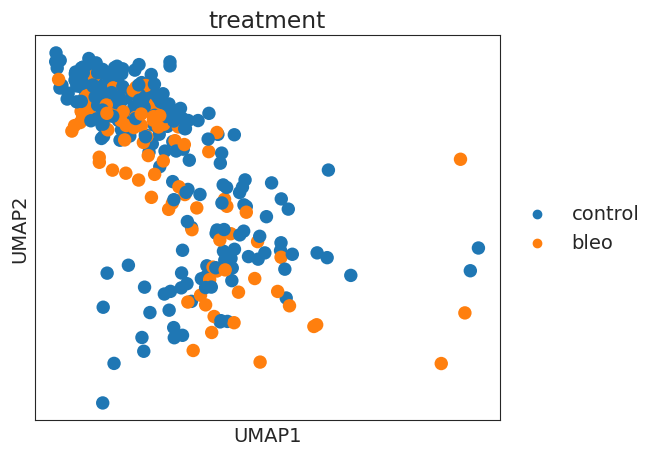

Started Diffxpy Calculation:	14-08-2024 18:25:49
training location model: True
training scale model: True
iter   0: ll=658836.880729
caught 18 linalg singular matrix errors
iter   1: ll=599409.349322, converged: 0.00% (loc: 0.45%, scale update: False), in 0.37sec
iter   2: ll=586225.207797, converged: 0.00% (loc: 0.45%, scale update: False), in 0.37sec
iter   3: ll=585477.999260, converged: 0.00% (loc: 0.45%, scale update: False), in 0.36sec
iter   4: ll=585472.022998, converged: 0.00% (loc: 0.45%, scale update: False), in 0.36sec
iter   5: ll=585471.975828, converged: 0.00% (loc: 11.43%, scale update: False), in 0.41sec
iter   6: ll=571355.902058, converged: 0.00% (loc: 0.00%, scale update: True), in 6.57sec
caught 18 linalg singular matrix errors
iter   7: ll=571283.420575, converged: 0.00% (loc: 0.50%, scale update: False), in 0.60sec
iter   8: ll=571282.173828, converged: 0.00% (loc: 3.27%, scale update: False), in 0.75sec
iter   9: ll=571282.161921, converged: 0.00% (loc: 36.03%, 

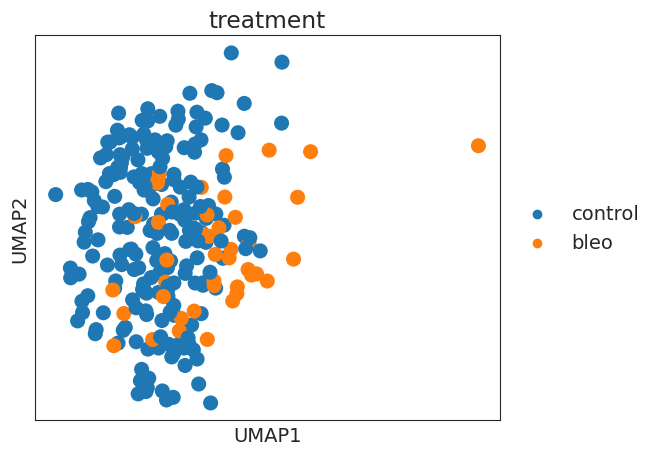

Started Diffxpy Calculation:	14-08-2024 18:26:30
training location model: True
training scale model: True
iter   0: ll=691068.818863
caught 122 linalg singular matrix errors
iter   1: ll=627558.348169, converged: 0.00% (loc: 3.42%, scale update: False), in 0.36sec
iter   2: ll=612425.066748, converged: 0.00% (loc: 3.42%, scale update: False), in 0.36sec
iter   3: ll=611275.405028, converged: 0.00% (loc: 3.42%, scale update: False), in 0.36sec
iter   4: ll=611252.876376, converged: 0.00% (loc: 3.42%, scale update: False), in 0.37sec
iter   5: ll=611252.483133, converged: 0.00% (loc: 3.87%, scale update: False), in 0.70sec
iter   6: ll=520885.619083, converged: 0.00% (loc: 0.00%, scale update: True), in 3.83sec
caught 122 linalg singular matrix errors
iter   7: ll=520606.839587, converged: 0.00% (loc: 3.04%, scale update: False), in 0.45sec
iter   8: ll=520580.047554, converged: 0.00% (loc: 4.87%, scale update: False), in 0.63sec
iter   9: ll=520577.853616, converged: 0.00% (loc: 16.68%,

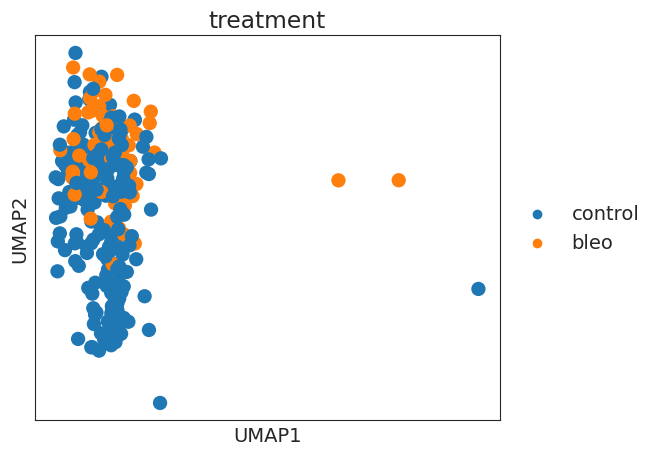

Started Diffxpy Calculation:	14-08-2024 18:27:21
training location model: True
training scale model: True
iter   0: ll=908544.407389
caught 39 linalg singular matrix errors
iter   1: ll=832705.335087, converged: 0.00% (loc: 2.02%, scale update: False), in 0.43sec
iter   2: ll=814042.760188, converged: 0.00% (loc: 2.02%, scale update: False), in 0.80sec
iter   3: ll=812428.806181, converged: 0.00% (loc: 2.02%, scale update: False), in 0.47sec
iter   4: ll=812381.564293, converged: 0.00% (loc: 2.02%, scale update: False), in 0.45sec
iter   5: ll=812380.072522, converged: 0.00% (loc: 2.22%, scale update: False), in 0.42sec
iter   6: ll=618986.708879, converged: 0.00% (loc: 0.00%, scale update: True), in 4.45sec
caught 39 linalg singular matrix errors
iter   7: ll=618394.718282, converged: 0.00% (loc: 0.95%, scale update: False), in 0.56sec
iter   8: ll=618318.057486, converged: 0.00% (loc: 1.76%, scale update: False), in 1.26sec
iter   9: ll=618313.917229, converged: 0.00% (loc: 8.07%, sc

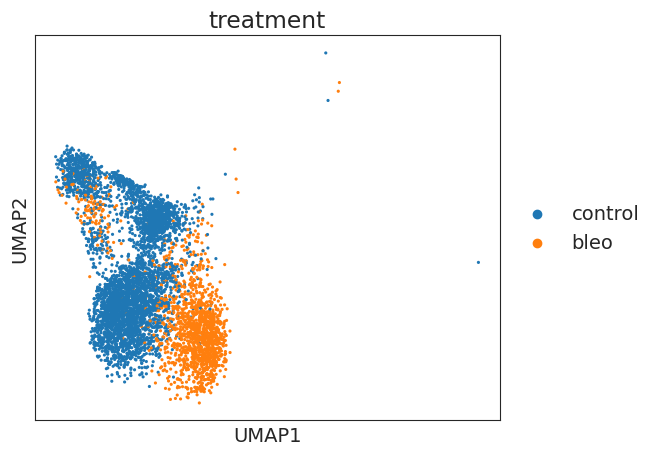

Started Diffxpy Calculation:	14-08-2024 18:28:24
training location model: True
training scale model: True
iter   0: ll=11191159.740881
iter   1: ll=10233590.472491, converged: 0.00% (loc: 0.00%, scale update: False), in 1.96sec
iter   2: ll=10012947.981949, converged: 0.00% (loc: 0.00%, scale update: False), in 1.91sec
iter   3: ll=10000645.545268, converged: 0.00% (loc: 0.00%, scale update: False), in 1.84sec
iter   4: ll=10000591.594627, converged: 0.00% (loc: 0.00%, scale update: False), in 1.81sec
iter   5: ll=10000591.572824, converged: 0.00% (loc: 8.00%, scale update: False), in 2.09sec
iter   6: ll=9761586.488909, converged: 0.00% (loc: 0.00%, scale update: True), in 24.70sec
iter   7: ll=9761088.615599, converged: 0.00% (loc: 0.03%, scale update: False), in 2.04sec
iter   8: ll=9761086.212562, converged: 0.00% (loc: 2.31%, scale update: False), in 1.97sec
iter   9: ll=9761086.200208, converged: 0.00% (loc: 35.26%, scale update: False), in 1.78sec
iter  10: ll=9761086.200110, co

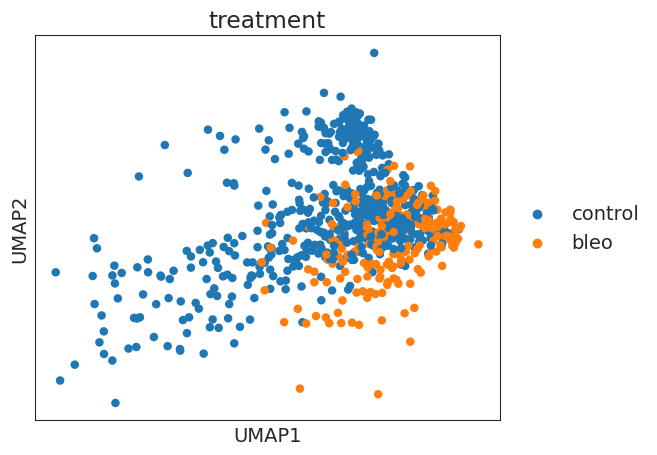

Started Diffxpy Calculation:	14-08-2024 18:30:42
training location model: True
training scale model: True
iter   0: ll=1885031.785198
caught 2 linalg singular matrix errors
iter   1: ll=1712944.554903, converged: 0.00% (loc: 0.05%, scale update: False), in 0.43sec
iter   2: ll=1672457.177642, converged: 0.00% (loc: 0.05%, scale update: False), in 0.41sec
iter   3: ll=1669747.754799, converged: 0.00% (loc: 0.05%, scale update: False), in 0.40sec
iter   4: ll=1669717.913840, converged: 0.00% (loc: 0.05%, scale update: False), in 0.39sec
iter   5: ll=1669717.772815, converged: 0.00% (loc: 1.05%, scale update: False), in 0.40sec
iter   6: ll=1644358.025356, converged: 0.00% (loc: 0.00%, scale update: True), in 5.82sec
caught 2 linalg singular matrix errors
iter   7: ll=1644055.468908, converged: 0.00% (loc: 0.05%, scale update: False), in 0.40sec
iter   8: ll=1644050.251158, converged: 0.00% (loc: 1.62%, scale update: False), in 0.41sec
iter   9: ll=1644050.172293, converged: 0.00% (loc: 1

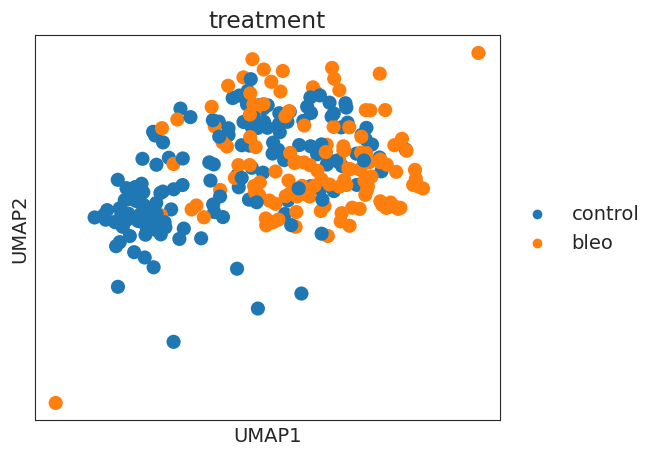

Started Diffxpy Calculation:	14-08-2024 18:31:29
training location model: True
training scale model: True
iter   0: ll=1099611.208651
caught 15 linalg singular matrix errors
iter   1: ll=1010001.474498, converged: 0.00% (loc: 1.44%, scale update: False), in 1.36sec
iter   2: ll=989262.747524, converged: 0.00% (loc: 1.44%, scale update: False), in 0.97sec
iter   3: ll=987693.373313, converged: 0.00% (loc: 1.44%, scale update: False), in 0.82sec
iter   4: ll=987659.902838, converged: 0.00% (loc: 1.44%, scale update: False), in 0.46sec
iter   5: ll=987659.308901, converged: 0.00% (loc: 1.92%, scale update: False), in 0.43sec
iter   6: ll=732368.994953, converged: 0.00% (loc: 0.00%, scale update: True), in 4.57sec
caught 15 linalg singular matrix errors
iter   7: ll=731815.023082, converged: 0.00% (loc: 0.42%, scale update: False), in 0.53sec
iter   8: ll=731761.187182, converged: 0.00% (loc: 1.82%, scale update: False), in 0.49sec
iter   9: ll=731745.564916, converged: 0.00% (loc: 11.42%,

In [17]:
out_folder = "/media/HDD_1/Janine/Aging_SingleCell/data/DGE_data/dge_meta_label_young/"

subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d20"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_young")

## d30

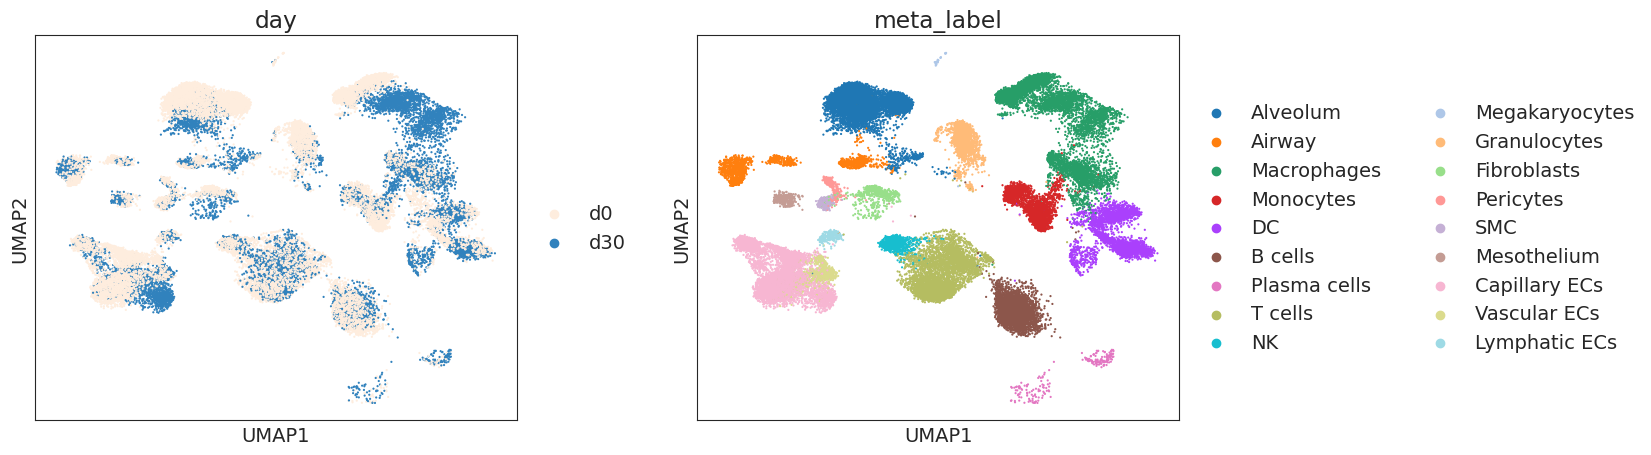

Alveolum - d30
(8398, 4933)


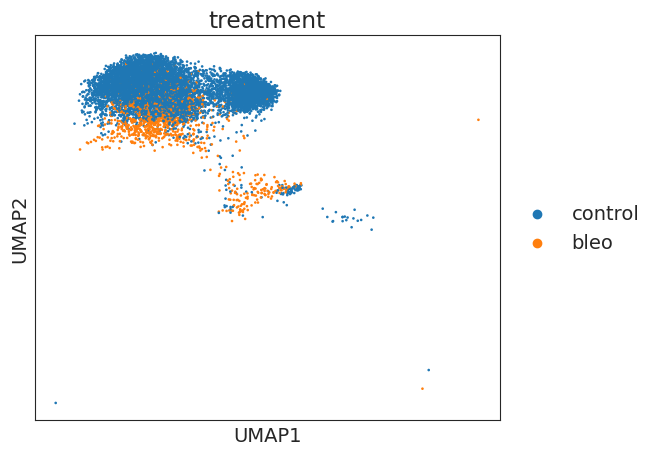

Started Diffxpy Calculation:	15-08-2024 09:34:50
training location model: True
training scale model: True
iter   0: ll=16586184.061954
iter   1: ll=15035780.848225, converged: 0.00% (loc: 0.04%, scale update: False), in 2.84sec
iter   2: ll=14670943.403782, converged: 0.00% (loc: 0.04%, scale update: False), in 2.79sec
iter   3: ll=14642418.768953, converged: 0.00% (loc: 0.04%, scale update: False), in 2.69sec
iter   4: ll=14641474.587096, converged: 0.00% (loc: 0.04%, scale update: False), in 2.96sec
iter   5: ll=14641443.226229, converged: 0.00% (loc: 0.08%, scale update: False), in 2.75sec
iter   6: ll=14388785.205159, converged: 0.00% (loc: 0.00%, scale update: True), in 42.53sec
iter   7: ll=14384840.337433, converged: 0.00% (loc: 0.00%, scale update: False), in 5.16sec
iter   8: ll=14384557.759773, converged: 0.00% (loc: 0.26%, scale update: False), in 4.53sec
iter   9: ll=14384538.925537, converged: 0.00% (loc: 1.28%, scale update: False), in 4.16sec
iter  10: ll=14384537.750754

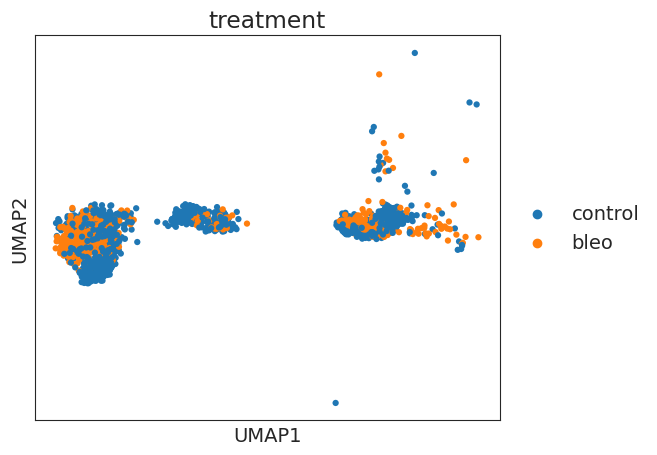

Started Diffxpy Calculation:	15-08-2024 09:40:01
training location model: True
training scale model: True
iter   0: ll=15581575.309782
iter   1: ll=14631848.224368, converged: 0.00% (loc: 4.78%, scale update: False), in 2.26sec
iter   2: ll=14304203.403989, converged: 0.00% (loc: 4.78%, scale update: False), in 3.38sec
iter   3: ll=14235924.737231, converged: 0.00% (loc: 4.78%, scale update: False), in 2.95sec
iter   4: ll=14226408.417769, converged: 0.00% (loc: 4.78%, scale update: False), in 2.41sec
iter   5: ll=14225354.837948, converged: 0.00% (loc: 4.80%, scale update: False), in 2.97sec
iter   6: ll=5228389.994601, converged: 0.00% (loc: 0.00%, scale update: True), in 16.29sec
iter   7: ll=5206583.530161, converged: 0.00% (loc: 0.00%, scale update: False), in 1.60sec
iter   8: ll=5204365.549462, converged: 0.00% (loc: 0.31%, scale update: False), in 1.56sec
iter   9: ll=5204103.475097, converged: 0.00% (loc: 1.19%, scale update: False), in 2.03sec
iter  10: ll=5204090.721437, con

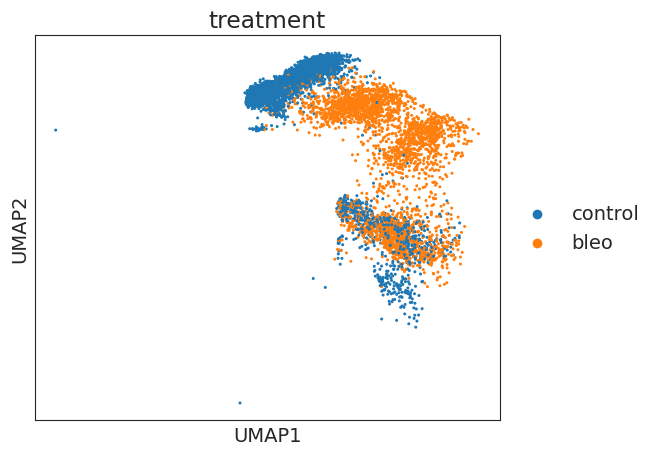

Started Diffxpy Calculation:	15-08-2024 09:42:47
training location model: True
training scale model: True
iter   0: ll=18765097.958334
iter   1: ll=16914385.146950, converged: 0.00% (loc: 0.02%, scale update: False), in 4.63sec
iter   2: ll=16417885.756705, converged: 0.00% (loc: 0.02%, scale update: False), in 3.65sec
iter   3: ll=16363385.947247, converged: 0.00% (loc: 0.02%, scale update: False), in 4.24sec
iter   4: ll=16360773.429244, converged: 0.00% (loc: 0.02%, scale update: False), in 2.71sec
iter   5: ll=16360685.861990, converged: 0.00% (loc: 0.02%, scale update: False), in 2.77sec
iter   6: ll=16234789.656683, converged: 0.00% (loc: 0.00%, scale update: True), in 52.28sec
iter   7: ll=16232763.952036, converged: 0.00% (loc: 0.02%, scale update: False), in 2.73sec
iter   8: ll=16232648.864156, converged: 0.00% (loc: 0.80%, scale update: False), in 2.89sec
iter   9: ll=16232641.896767, converged: 0.00% (loc: 4.18%, scale update: False), in 2.78sec
iter  10: ll=16232641.522303

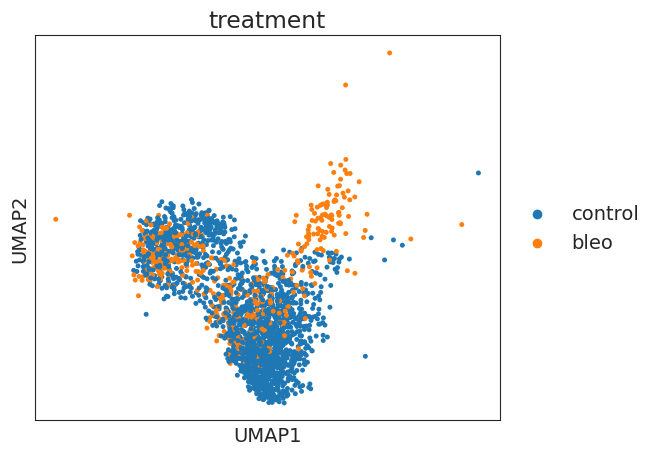

Started Diffxpy Calculation:	15-08-2024 09:47:55
training location model: True
training scale model: True
iter   0: ll=6098928.158806
caught 2 linalg singular matrix errors
iter   1: ll=5418117.264556, converged: 0.00% (loc: 0.05%, scale update: False), in 2.22sec
iter   2: ll=5265404.968881, converged: 0.00% (loc: 0.05%, scale update: False), in 1.31sec
iter   3: ll=5255503.636223, converged: 0.00% (loc: 0.05%, scale update: False), in 1.38sec
iter   4: ll=5255384.487532, converged: 0.00% (loc: 0.05%, scale update: False), in 1.31sec
iter   5: ll=5255383.849066, converged: 0.00% (loc: 0.88%, scale update: False), in 1.21sec
iter   6: ll=5229174.761414, converged: 0.00% (loc: 0.00%, scale update: True), in 15.12sec
caught 2 linalg singular matrix errors
iter   7: ll=5228857.828043, converged: 0.00% (loc: 0.12%, scale update: False), in 1.89sec
iter   8: ll=5228854.693901, converged: 0.00% (loc: 2.09%, scale update: False), in 1.64sec
iter   9: ll=5228854.667713, converged: 0.00% (loc: 

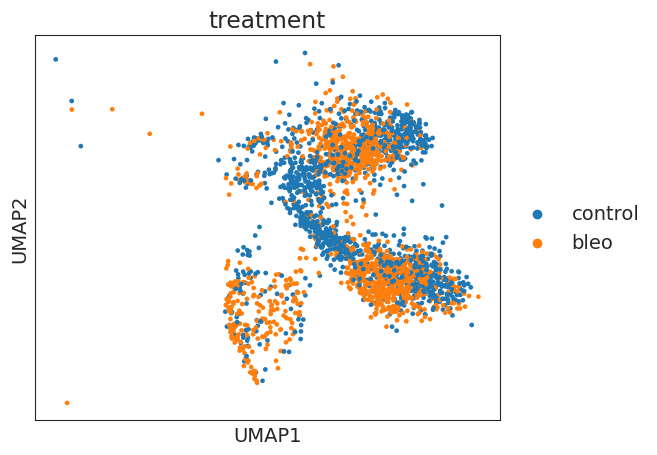

Started Diffxpy Calculation:	15-08-2024 09:49:30
training location model: True
training scale model: True
iter   0: ll=7038361.850080
iter   1: ll=6259125.302107, converged: 0.00% (loc: 0.00%, scale update: False), in 2.29sec
iter   2: ll=6072847.846437, converged: 0.00% (loc: 0.00%, scale update: False), in 1.91sec
iter   3: ll=6058179.437430, converged: 0.00% (loc: 0.00%, scale update: False), in 1.43sec
iter   4: ll=6057871.535238, converged: 0.00% (loc: 0.00%, scale update: False), in 1.67sec
iter   5: ll=6057867.706274, converged: 0.00% (loc: 0.30%, scale update: False), in 1.79sec
iter   6: ll=6043134.285815, converged: 0.00% (loc: 0.00%, scale update: True), in 17.57sec
iter   7: ll=6042862.876296, converged: 0.00% (loc: 0.04%, scale update: False), in 3.32sec
iter   8: ll=6042858.076566, converged: 0.00% (loc: 2.59%, scale update: False), in 3.50sec
iter   9: ll=6042857.994381, converged: 0.00% (loc: 18.60%, scale update: False), in 2.47sec
iter  10: ll=6042857.992890, converge

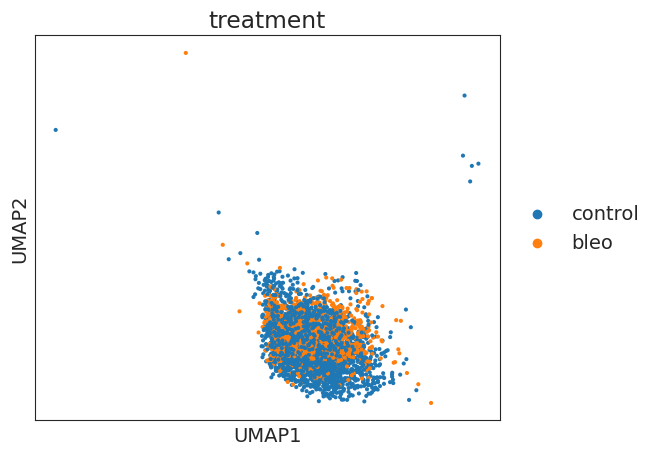

Started Diffxpy Calculation:	15-08-2024 09:51:30
training location model: True
training scale model: True
iter   0: ll=4810940.478464
iter   1: ll=4338841.265448, converged: 0.00% (loc: 0.00%, scale update: False), in 1.93sec
iter   2: ll=4231259.388319, converged: 0.00% (loc: 0.00%, scale update: False), in 1.60sec
iter   3: ll=4225684.827570, converged: 0.00% (loc: 0.00%, scale update: False), in 1.83sec
iter   4: ll=4225668.734619, converged: 0.00% (loc: 0.00%, scale update: False), in 1.56sec
iter   5: ll=4225668.732191, converged: 0.00% (loc: 37.19%, scale update: False), in 1.30sec
iter   6: ll=4152430.191706, converged: 0.00% (loc: 0.00%, scale update: True), in 12.69sec
iter   7: ll=4152384.899035, converged: 0.00% (loc: 0.00%, scale update: False), in 1.44sec
iter   8: ll=4152384.819232, converged: 0.00% (loc: 15.55%, scale update: False), in 1.52sec
iter   9: ll=4152384.819085, converged: 0.00% (loc: 90.97%, scale update: False), in 1.56sec
iter  10: ll=4152384.819085, conver

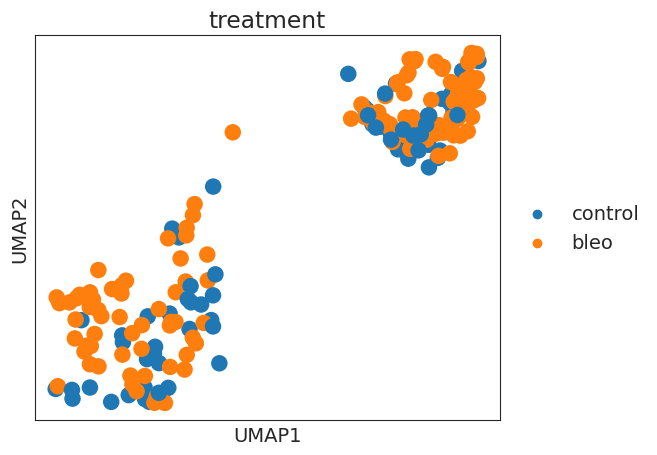

Started Diffxpy Calculation:	15-08-2024 09:52:36
training location model: True
training scale model: True
iter   0: ll=3817221.544149
caught 33 linalg singular matrix errors
iter   1: ll=3757914.516289, converged: 0.00% (loc: 22.59%, scale update: False), in 0.44sec
iter   2: ll=3736288.882346, converged: 0.00% (loc: 22.59%, scale update: False), in 0.58sec
iter   3: ll=3731283.822114, converged: 0.00% (loc: 22.59%, scale update: False), in 0.51sec
iter   4: ll=3730513.191996, converged: 0.00% (loc: 22.59%, scale update: False), in 0.38sec
iter   5: ll=3730429.589092, converged: 0.00% (loc: 22.71%, scale update: False), in 0.24sec
iter   6: ll=359775.352800, converged: 0.00% (loc: 0.00%, scale update: True), in 3.67sec
caught 32 linalg singular matrix errors
iter   7: ll=352221.632992, converged: 0.00% (loc: 2.45%, scale update: False), in 0.46sec
iter   8: ll=350161.756091, converged: 0.00% (loc: 4.56%, scale update: False), in 0.33sec
iter   9: ll=350006.013355, converged: 0.00% (loc

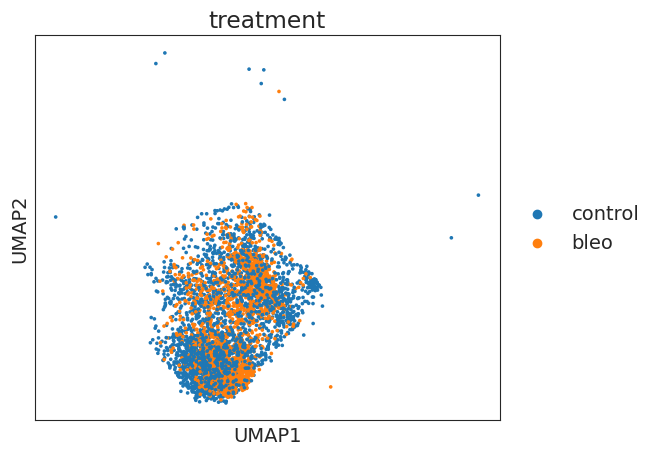

Started Diffxpy Calculation:	15-08-2024 09:53:21
training location model: True
training scale model: True
iter   0: ll=6520171.780765
iter   1: ll=5896189.895818, converged: 0.00% (loc: 0.00%, scale update: False), in 1.78sec
iter   2: ll=5759839.980964, converged: 0.00% (loc: 0.00%, scale update: False), in 2.00sec
iter   3: ll=5753203.230412, converged: 0.00% (loc: 0.00%, scale update: False), in 1.52sec
iter   4: ll=5753184.746282, converged: 0.00% (loc: 0.00%, scale update: False), in 1.72sec
iter   5: ll=5753184.744063, converged: 0.00% (loc: 42.43%, scale update: False), in 1.40sec
iter   6: ll=5671957.768787, converged: 0.00% (loc: 0.00%, scale update: True), in 15.10sec
iter   7: ll=5671914.296350, converged: 0.00% (loc: 0.15%, scale update: False), in 1.39sec
iter   8: ll=5671914.246503, converged: 0.00% (loc: 20.94%, scale update: False), in 1.28sec
iter   9: ll=5671914.246426, converged: 0.00% (loc: 96.83%, scale update: False), in 1.06sec
iter  10: ll=5671914.246425, conver

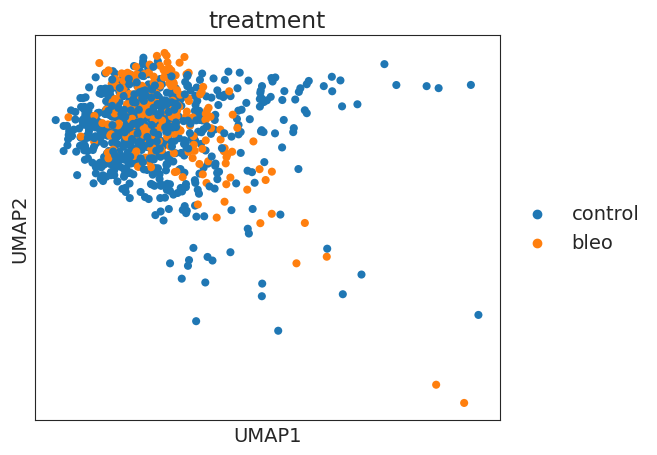

Started Diffxpy Calculation:	15-08-2024 09:54:36
training location model: True
training scale model: True
iter   0: ll=1344658.115321
iter   1: ll=1219523.305940, converged: 0.00% (loc: 0.00%, scale update: False), in 0.29sec
iter   2: ll=1192106.997968, converged: 0.00% (loc: 0.00%, scale update: False), in 0.30sec
iter   3: ll=1190756.761387, converged: 0.00% (loc: 0.00%, scale update: False), in 0.31sec
iter   4: ll=1190752.615939, converged: 0.00% (loc: 0.00%, scale update: False), in 0.29sec
iter   5: ll=1190752.614530, converged: 0.00% (loc: 37.57%, scale update: False), in 0.30sec
iter   6: ll=1170203.671444, converged: 0.00% (loc: 0.00%, scale update: True), in 6.21sec
iter   7: ll=1170178.693261, converged: 0.00% (loc: 0.00%, scale update: False), in 0.33sec
iter   8: ll=1170178.634855, converged: 0.00% (loc: 13.28%, scale update: False), in 0.57sec
iter   9: ll=1170178.634747, converged: 0.00% (loc: 89.46%, scale update: False), in 0.72sec
iter  10: ll=1170178.634747, converg

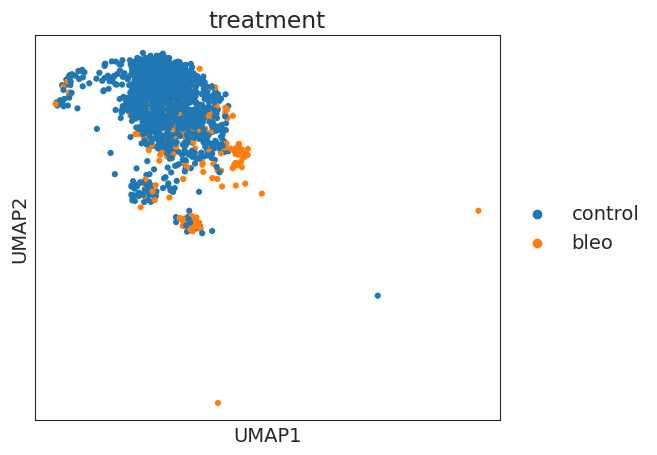

Started Diffxpy Calculation:	15-08-2024 09:55:05
training location model: True
training scale model: True
iter   0: ll=1678992.079357
iter   1: ll=1507319.935292, converged: 0.00% (loc: 0.00%, scale update: False), in 0.44sec
iter   2: ll=1465310.333400, converged: 0.00% (loc: 0.00%, scale update: False), in 0.71sec
iter   3: ll=1462804.073688, converged: 0.00% (loc: 0.00%, scale update: False), in 0.61sec
iter   4: ll=1462792.967602, converged: 0.00% (loc: 0.00%, scale update: False), in 0.78sec
iter   5: ll=1462792.963996, converged: 0.00% (loc: 19.47%, scale update: False), in 0.64sec
iter   6: ll=1437039.302167, converged: 0.00% (loc: 0.00%, scale update: True), in 5.96sec
iter   7: ll=1437024.020757, converged: 0.00% (loc: 0.00%, scale update: False), in 1.09sec
iter   8: ll=1437023.995693, converged: 0.00% (loc: 17.38%, scale update: False), in 1.27sec
iter   9: ll=1437023.995597, converged: 0.00% (loc: 94.17%, scale update: False), in 1.01sec
iter  10: ll=1437023.995595, converg

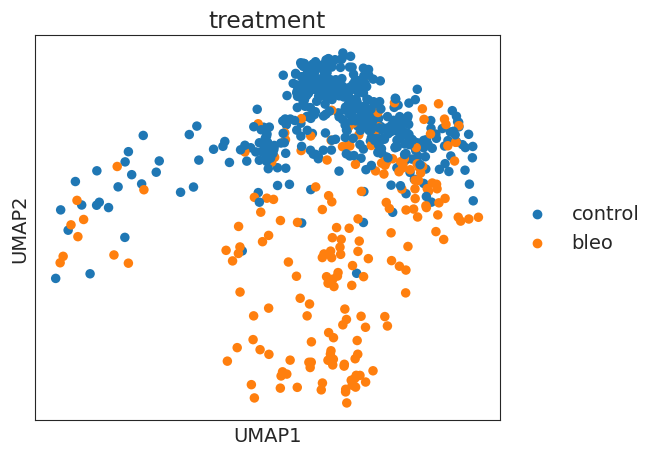

Started Diffxpy Calculation:	15-08-2024 09:55:35
training location model: True
training scale model: True
iter   0: ll=2480895.690732
caught 35 linalg singular matrix errors
iter   1: ll=2300383.574940, converged: 0.00% (loc: 1.65%, scale update: False), in 0.57sec
iter   2: ll=2249346.625066, converged: 0.00% (loc: 1.65%, scale update: False), in 0.54sec
iter   3: ll=2242873.069232, converged: 0.00% (loc: 1.65%, scale update: False), in 0.55sec
iter   4: ll=2242426.984926, converged: 0.00% (loc: 1.65%, scale update: False), in 0.73sec
iter   5: ll=2242398.695509, converged: 0.00% (loc: 1.65%, scale update: False), in 0.54sec
iter   6: ll=1714304.533489, converged: 0.00% (loc: 0.00%, scale update: True), in 7.55sec
caught 34 linalg singular matrix errors
iter   7: ll=1713175.562024, converged: 0.00% (loc: 0.62%, scale update: False), in 0.82sec
iter   8: ll=1712997.624389, converged: 0.00% (loc: 1.22%, scale update: False), in 1.22sec
iter   9: ll=1712977.318940, converged: 0.00% (loc:

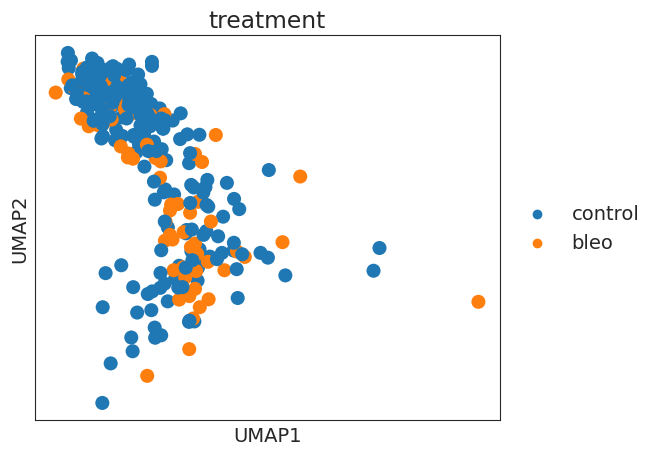

Started Diffxpy Calculation:	15-08-2024 09:56:54
training location model: True
training scale model: True
iter   0: ll=661159.604004
caught 20 linalg singular matrix errors
iter   1: ll=602786.156780, converged: 0.00% (loc: 0.59%, scale update: False), in 0.40sec
iter   2: ll=589996.030903, converged: 0.00% (loc: 0.59%, scale update: False), in 0.61sec
iter   3: ll=589268.099459, converged: 0.00% (loc: 0.59%, scale update: False), in 0.39sec
iter   4: ll=589261.236563, converged: 0.00% (loc: 0.59%, scale update: False), in 0.85sec
iter   5: ll=589261.164826, converged: 0.00% (loc: 7.66%, scale update: False), in 0.90sec
iter   6: ll=564384.910523, converged: 0.00% (loc: 0.00%, scale update: True), in 6.29sec
caught 20 linalg singular matrix errors
iter   7: ll=564273.621633, converged: 0.00% (loc: 0.52%, scale update: False), in 0.43sec
iter   8: ll=564269.581890, converged: 0.00% (loc: 2.62%, scale update: False), in 0.41sec
iter   9: ll=564269.507007, converged: 0.00% (loc: 25.42%, s

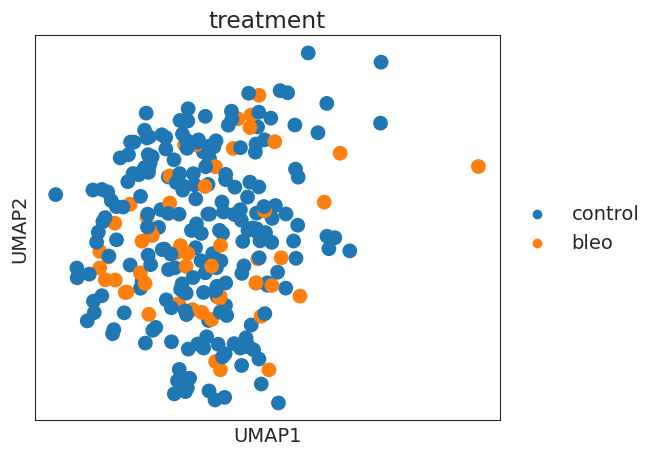

Started Diffxpy Calculation:	15-08-2024 09:57:54
training location model: True
training scale model: True
iter   0: ll=1074590.478611
caught 43 linalg singular matrix errors
iter   1: ll=998366.969948, converged: 0.00% (loc: 3.47%, scale update: False), in 0.42sec
iter   2: ll=980425.344326, converged: 0.00% (loc: 3.47%, scale update: False), in 0.41sec
iter   3: ll=979062.377916, converged: 0.00% (loc: 3.47%, scale update: False), in 0.39sec
iter   4: ll=979035.358459, converged: 0.00% (loc: 3.47%, scale update: False), in 0.41sec
iter   5: ll=979034.977194, converged: 0.00% (loc: 3.76%, scale update: False), in 0.56sec
iter   6: ll=600905.664903, converged: 0.00% (loc: 0.00%, scale update: True), in 5.11sec
caught 43 linalg singular matrix errors
iter   7: ll=600336.528640, converged: 0.00% (loc: 1.59%, scale update: False), in 0.48sec
iter   8: ll=600290.413527, converged: 0.00% (loc: 3.92%, scale update: False), in 0.46sec
iter   9: ll=600288.492211, converged: 0.00% (loc: 18.20%, 

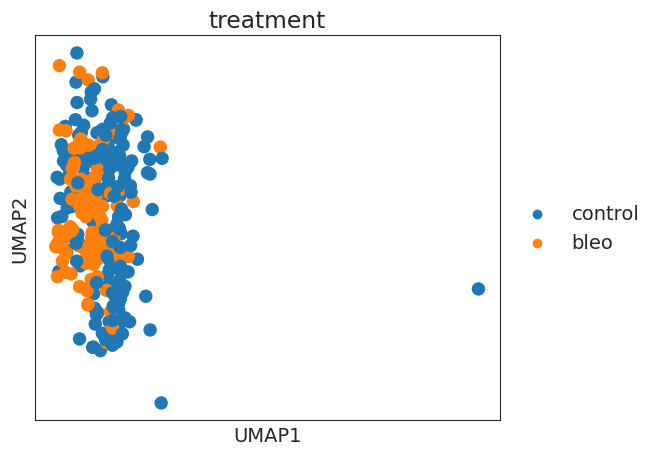

Started Diffxpy Calculation:	15-08-2024 09:58:56
training location model: True
training scale model: True
iter   0: ll=1197231.813563
caught 5 linalg singular matrix errors
iter   1: ll=1097015.833363, converged: 0.00% (loc: 1.68%, scale update: False), in 0.78sec
iter   2: ll=1072127.764692, converged: 0.00% (loc: 1.68%, scale update: False), in 0.66sec
iter   3: ll=1069833.006242, converged: 0.00% (loc: 1.68%, scale update: False), in 0.65sec
iter   4: ll=1069752.894754, converged: 0.00% (loc: 1.68%, scale update: False), in 0.86sec
iter   5: ll=1069750.038987, converged: 0.00% (loc: 1.77%, scale update: False), in 0.83sec
iter   6: ll=744845.769358, converged: 0.00% (loc: 0.00%, scale update: True), in 5.60sec
caught 5 linalg singular matrix errors
iter   7: ll=743627.891125, converged: 0.00% (loc: 0.24%, scale update: False), in 0.90sec
iter   8: ll=743311.140629, converged: 0.00% (loc: 1.16%, scale update: False), in 0.47sec
iter   9: ll=743266.494271, converged: 0.00% (loc: 8.63%

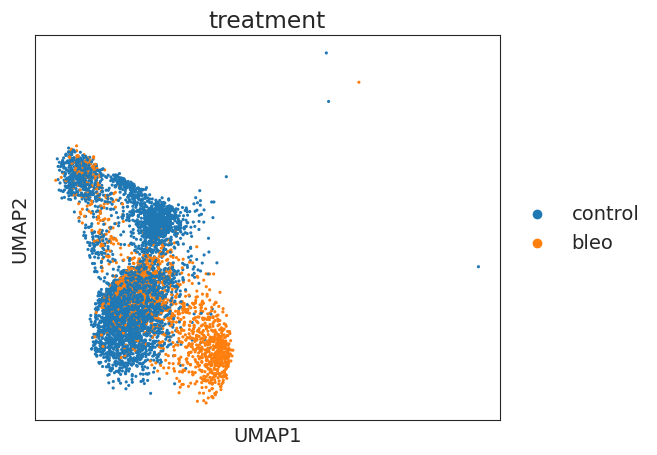

Started Diffxpy Calculation:	15-08-2024 09:59:58
training location model: True
training scale model: True
iter   0: ll=12578456.327723
iter   1: ll=11491022.566213, converged: 0.00% (loc: 0.00%, scale update: False), in 2.88sec
iter   2: ll=11245146.280821, converged: 0.00% (loc: 0.00%, scale update: False), in 2.52sec
iter   3: ll=11231496.348616, converged: 0.00% (loc: 0.00%, scale update: False), in 2.18sec
iter   4: ll=11231428.057963, converged: 0.00% (loc: 0.00%, scale update: False), in 2.15sec
iter   5: ll=11231428.002872, converged: 0.00% (loc: 1.70%, scale update: False), in 2.36sec
iter   6: ll=11015107.879619, converged: 0.00% (loc: 0.00%, scale update: True), in 30.52sec
iter   7: ll=11014271.197888, converged: 0.00% (loc: 0.02%, scale update: False), in 1.86sec
iter   8: ll=11014264.573322, converged: 0.00% (loc: 1.41%, scale update: False), in 1.96sec
iter   9: ll=11014264.525203, converged: 0.00% (loc: 16.13%, scale update: False), in 1.89sec
iter  10: ll=11014264.52478

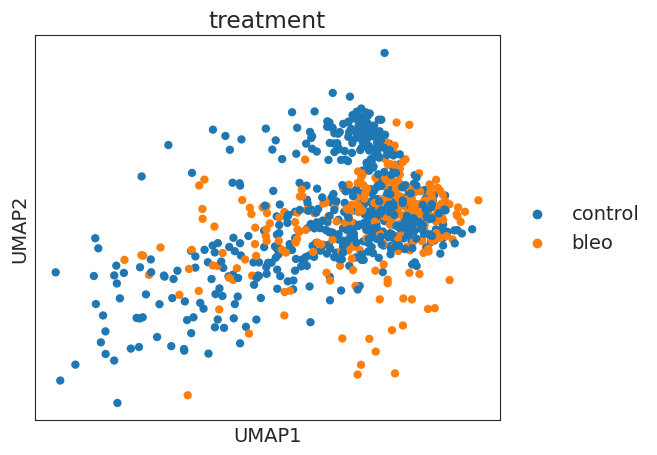

Started Diffxpy Calculation:	15-08-2024 10:02:40
training location model: True
training scale model: True
iter   0: ll=2356673.240905
iter   1: ll=2138500.385106, converged: 0.00% (loc: 0.23%, scale update: False), in 0.85sec
iter   2: ll=2086193.330379, converged: 0.00% (loc: 0.23%, scale update: False), in 0.67sec
iter   3: ll=2082273.951499, converged: 0.00% (loc: 0.23%, scale update: False), in 0.83sec
iter   4: ll=2082208.292442, converged: 0.00% (loc: 0.23%, scale update: False), in 1.09sec
iter   5: ll=2082207.606226, converged: 0.00% (loc: 0.42%, scale update: False), in 1.68sec
iter   6: ll=1963532.282765, converged: 0.00% (loc: 0.00%, scale update: True), in 9.81sec
iter   7: ll=1962728.727212, converged: 0.00% (loc: 0.04%, scale update: False), in 0.45sec
iter   8: ll=1962622.719703, converged: 0.00% (loc: 1.50%, scale update: False), in 0.43sec
iter   9: ll=1962611.523873, converged: 0.00% (loc: 10.87%, scale update: False), in 0.44sec
iter  10: ll=1962611.144096, converged

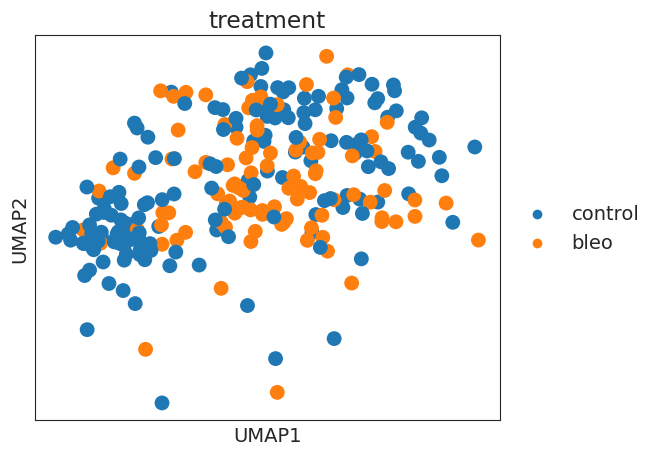

Started Diffxpy Calculation:	15-08-2024 10:03:33
training location model: True
training scale model: True
iter   0: ll=1670587.959537
caught 27 linalg singular matrix errors
iter   1: ll=1573497.073136, converged: 0.00% (loc: 3.88%, scale update: False), in 0.48sec
iter   2: ll=1548182.540226, converged: 0.00% (loc: 3.88%, scale update: False), in 0.47sec
iter   3: ll=1545012.639520, converged: 0.00% (loc: 3.88%, scale update: False), in 0.46sec
iter   4: ll=1544654.573500, converged: 0.00% (loc: 3.88%, scale update: False), in 0.65sec
iter   5: ll=1544593.473147, converged: 0.00% (loc: 3.94%, scale update: False), in 1.65sec
iter   6: ll=760451.990423, converged: 0.00% (loc: 0.00%, scale update: True), in 7.50sec
caught 26 linalg singular matrix errors
iter   7: ll=758711.111214, converged: 0.00% (loc: 0.63%, scale update: False), in 1.22sec
iter   8: ll=758322.460210, converged: 0.00% (loc: 1.31%, scale update: False), in 1.21sec
iter   9: ll=758272.657015, converged: 0.00% (loc: 5.5

In [27]:
out_folder = "/media/HDD_1/Janine/Aging_SingleCell/data/DGE_data/dge_meta_label_young/"
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d30"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_young")

## d37

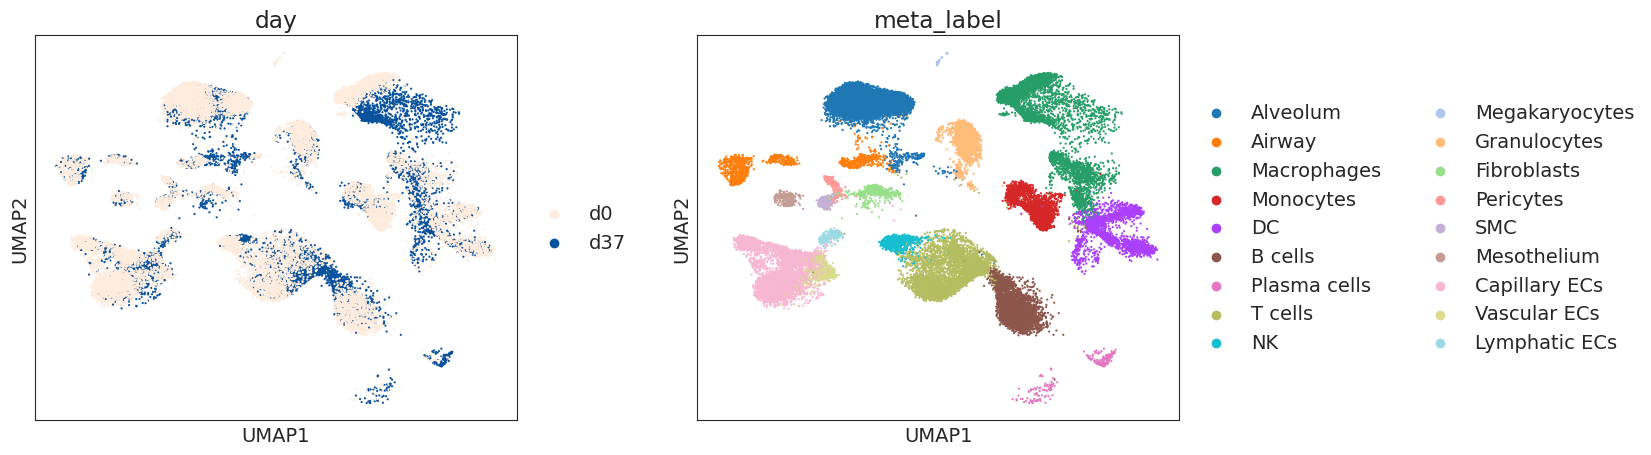

Alveolum - d37
(8642, 2787)


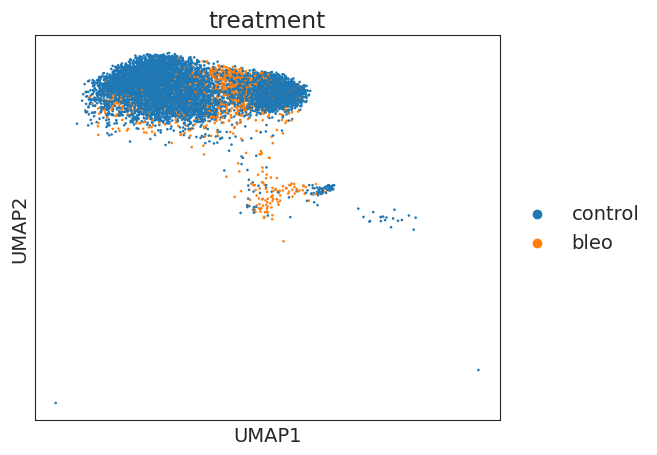

Started Diffxpy Calculation:	15-08-2024 10:04:55
training location model: True
training scale model: True
iter   0: ll=12605309.647676
iter   1: ll=11390156.847488, converged: 0.00% (loc: 0.00%, scale update: False), in 1.96sec
iter   2: ll=11120967.359629, converged: 0.00% (loc: 0.00%, scale update: False), in 2.00sec
iter   3: ll=11105888.112280, converged: 0.00% (loc: 0.00%, scale update: False), in 1.97sec
iter   4: ll=11105792.340355, converged: 0.00% (loc: 0.00%, scale update: False), in 2.00sec
iter   5: ll=11105792.140675, converged: 0.00% (loc: 5.71%, scale update: False), in 2.13sec
iter   6: ll=10923445.026388, converged: 0.00% (loc: 0.00%, scale update: True), in 31.22sec
iter   7: ll=10922618.659502, converged: 0.00% (loc: 0.00%, scale update: False), in 2.11sec
iter   8: ll=10922611.454046, converged: 0.00% (loc: 1.79%, scale update: False), in 1.87sec
iter   9: ll=10922611.375152, converged: 0.00% (loc: 17.26%, scale update: False), in 2.31sec
iter  10: ll=10922611.37395

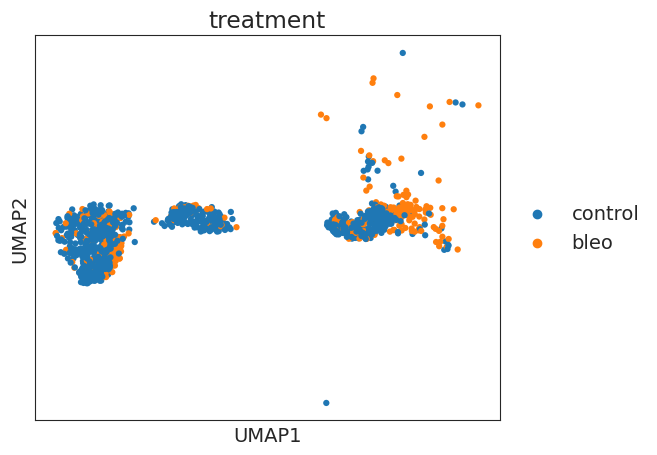

Started Diffxpy Calculation:	15-08-2024 10:07:38
training location model: True
training scale model: True
iter   0: ll=5912876.366424
iter   1: ll=5339419.061877, converged: 0.00% (loc: 0.47%, scale update: False), in 2.89sec
iter   2: ll=5168328.924019, converged: 0.00% (loc: 0.47%, scale update: False), in 2.99sec
iter   3: ll=5144197.702544, converged: 0.00% (loc: 0.47%, scale update: False), in 2.96sec
iter   4: ll=5142480.720907, converged: 0.00% (loc: 0.47%, scale update: False), in 2.43sec
iter   5: ll=5142376.786955, converged: 0.00% (loc: 0.51%, scale update: False), in 2.27sec
iter   6: ll=4386676.398959, converged: 0.00% (loc: 0.00%, scale update: True), in 13.05sec
iter   7: ll=4383840.682500, converged: 0.00% (loc: 0.00%, scale update: False), in 3.24sec
iter   8: ll=4383666.565083, converged: 0.00% (loc: 0.58%, scale update: False), in 2.69sec
iter   9: ll=4383651.679913, converged: 0.00% (loc: 3.30%, scale update: False), in 2.94sec
iter  10: ll=4383651.180216, converged

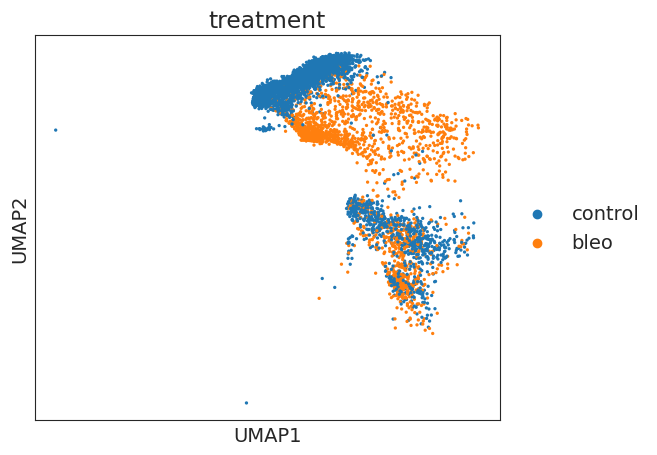

Started Diffxpy Calculation:	15-08-2024 10:09:44
training location model: True
training scale model: True
iter   0: ll=10238824.661644
iter   1: ll=9331327.540442, converged: 0.00% (loc: 0.00%, scale update: False), in 2.41sec
iter   2: ll=9128043.562403, converged: 0.00% (loc: 0.00%, scale update: False), in 2.64sec
iter   3: ll=9116560.480163, converged: 0.00% (loc: 0.00%, scale update: False), in 2.26sec
iter   4: ll=9116487.052466, converged: 0.00% (loc: 0.00%, scale update: False), in 2.07sec
iter   5: ll=9116486.883284, converged: 0.00% (loc: 6.60%, scale update: False), in 2.58sec
iter   6: ll=8949328.245677, converged: 0.00% (loc: 0.00%, scale update: True), in 23.94sec
iter   7: ll=8948595.250414, converged: 0.00% (loc: 0.06%, scale update: False), in 2.39sec
iter   8: ll=8948588.300358, converged: 0.00% (loc: 2.69%, scale update: False), in 2.04sec
iter   9: ll=8948588.239646, converged: 0.00% (loc: 20.94%, scale update: False), in 2.48sec
iter  10: ll=8948588.239016, converg

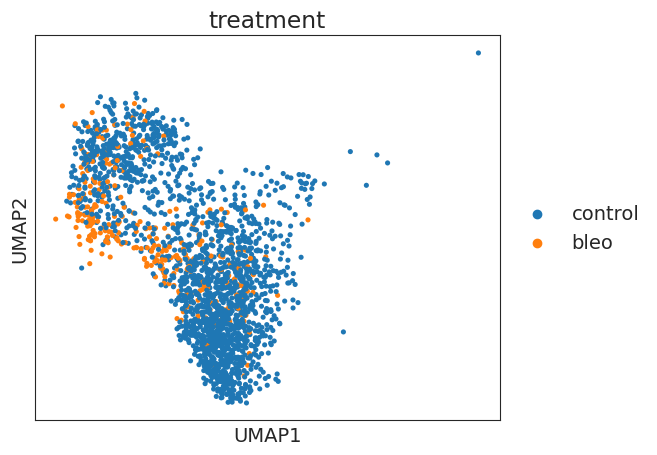

Started Diffxpy Calculation:	15-08-2024 10:12:10
training location model: True
training scale model: True
iter   0: ll=5506412.788267
caught 2 linalg singular matrix errors
iter   1: ll=4911634.658268, converged: 0.00% (loc: 0.05%, scale update: False), in 1.35sec
iter   2: ll=4775850.336852, converged: 0.00% (loc: 0.05%, scale update: False), in 1.66sec
iter   3: ll=4767002.678369, converged: 0.00% (loc: 0.05%, scale update: False), in 1.89sec
iter   4: ll=4766904.355915, converged: 0.00% (loc: 0.05%, scale update: False), in 1.59sec
iter   5: ll=4766903.927300, converged: 0.00% (loc: 0.72%, scale update: False), in 1.46sec
iter   6: ll=4735755.925480, converged: 0.00% (loc: 0.00%, scale update: True), in 12.50sec
caught 2 linalg singular matrix errors
iter   7: ll=4735343.795524, converged: 0.00% (loc: 0.10%, scale update: False), in 1.66sec
iter   8: ll=4735339.828678, converged: 0.00% (loc: 1.23%, scale update: False), in 1.77sec
iter   9: ll=4735339.798485, converged: 0.00% (loc: 

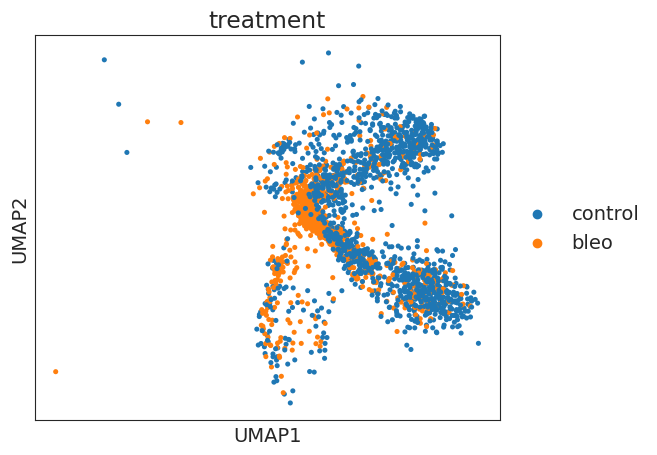

Started Diffxpy Calculation:	15-08-2024 10:13:40
training location model: True
training scale model: True
iter   0: ll=4231812.921772
iter   1: ll=3842750.530225, converged: 0.00% (loc: 0.00%, scale update: False), in 1.15sec
iter   2: ll=3755550.481848, converged: 0.00% (loc: 0.00%, scale update: False), in 1.37sec
iter   3: ll=3750644.735915, converged: 0.00% (loc: 0.00%, scale update: False), in 1.29sec
iter   4: ll=3750615.269024, converged: 0.00% (loc: 0.00%, scale update: False), in 1.20sec
iter   5: ll=3750615.229252, converged: 0.00% (loc: 7.61%, scale update: False), in 1.31sec
iter   6: ll=3690511.046256, converged: 0.00% (loc: 0.00%, scale update: True), in 12.17sec
iter   7: ll=3690233.151996, converged: 0.00% (loc: 0.00%, scale update: False), in 1.80sec
iter   8: ll=3690231.442419, converged: 0.00% (loc: 2.07%, scale update: False), in 1.68sec
iter   9: ll=3690231.434413, converged: 0.00% (loc: 28.68%, scale update: False), in 1.66sec
iter  10: ll=3690231.434370, converge

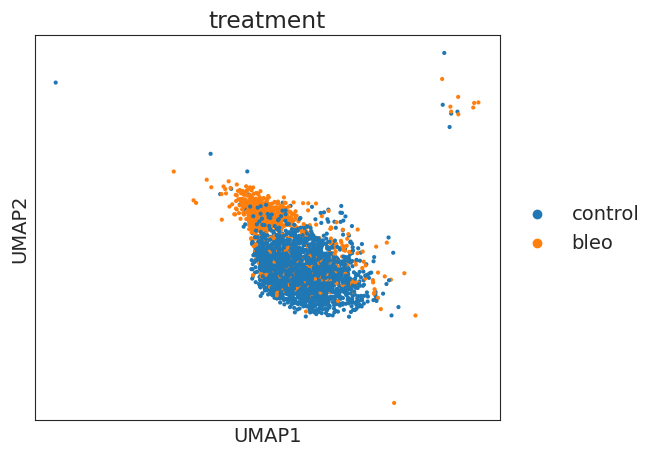

Started Diffxpy Calculation:	15-08-2024 10:14:51
training location model: True
training scale model: True
iter   0: ll=4227420.157408
iter   1: ll=3823407.597683, converged: 0.00% (loc: 0.00%, scale update: False), in 1.11sec
iter   2: ll=3725812.351437, converged: 0.00% (loc: 0.00%, scale update: False), in 1.00sec
iter   3: ll=3720112.891423, converged: 0.00% (loc: 0.00%, scale update: False), in 1.19sec
iter   4: ll=3720089.726113, converged: 0.00% (loc: 0.00%, scale update: False), in 1.28sec
iter   5: ll=3720089.722021, converged: 0.00% (loc: 22.98%, scale update: False), in 1.52sec
iter   6: ll=3639508.172991, converged: 0.00% (loc: 0.00%, scale update: True), in 11.98sec
iter   7: ll=3639455.268135, converged: 0.00% (loc: 0.04%, scale update: False), in 1.04sec
iter   8: ll=3639455.057662, converged: 0.00% (loc: 19.36%, scale update: False), in 1.00sec
iter   9: ll=3639455.056598, converged: 0.00% (loc: 91.82%, scale update: False), in 0.88sec
iter  10: ll=3639455.056585, conver

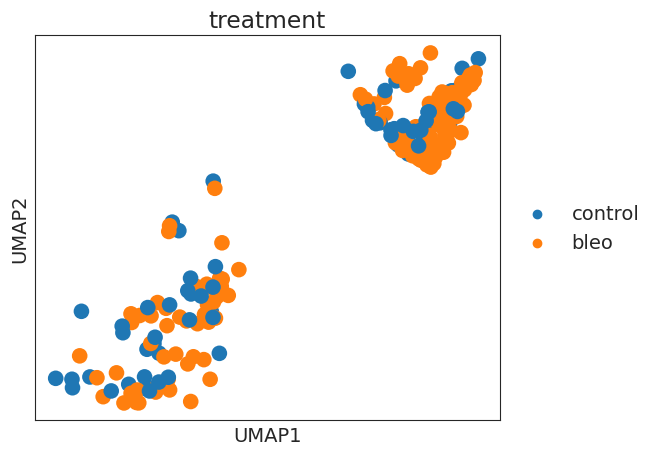

Started Diffxpy Calculation:	15-08-2024 10:15:46
training location model: True
training scale model: True
iter   0: ll=537398.245333
caught 14 linalg singular matrix errors
iter   1: ll=512630.730444, converged: 0.00% (loc: 4.60%, scale update: False), in 0.32sec
iter   2: ll=506039.385726, converged: 0.00% (loc: 4.60%, scale update: False), in 0.22sec
iter   3: ll=505334.223392, converged: 0.00% (loc: 4.60%, scale update: False), in 0.24sec
iter   4: ll=505300.470252, converged: 0.00% (loc: 4.60%, scale update: False), in 0.23sec
iter   5: ll=505298.871058, converged: 0.00% (loc: 4.99%, scale update: False), in 0.23sec
iter   6: ll=222242.080142, converged: 0.00% (loc: 0.00%, scale update: True), in 2.18sec
caught 14 linalg singular matrix errors
iter   7: ll=221827.399075, converged: 0.00% (loc: 1.50%, scale update: False), in 0.24sec
iter   8: ll=221761.559023, converged: 0.00% (loc: 3.00%, scale update: False), in 0.24sec
iter   9: ll=221757.725398, converged: 0.00% (loc: 12.10%, s

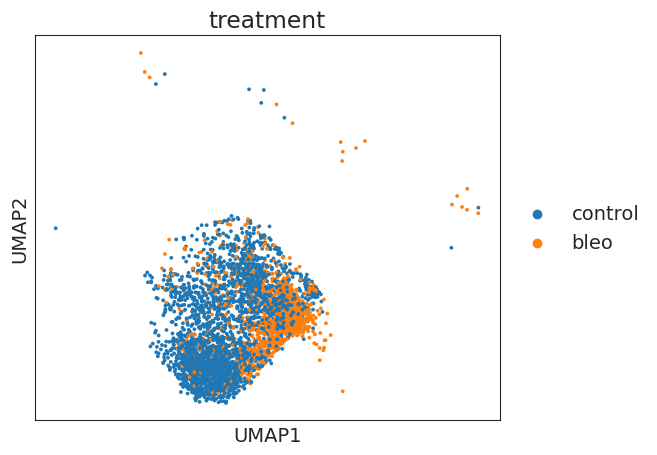

Started Diffxpy Calculation:	15-08-2024 10:16:20
training location model: True
training scale model: True
iter   0: ll=5255641.139214
iter   1: ll=4768352.301835, converged: 0.00% (loc: 0.00%, scale update: False), in 1.24sec
iter   2: ll=4652128.252586, converged: 0.00% (loc: 0.00%, scale update: False), in 1.20sec
iter   3: ll=4645414.925086, converged: 0.00% (loc: 0.00%, scale update: False), in 1.28sec
iter   4: ll=4645387.061678, converged: 0.00% (loc: 0.00%, scale update: False), in 1.18sec
iter   5: ll=4645387.057556, converged: 0.00% (loc: 23.67%, scale update: False), in 1.15sec
iter   6: ll=4553287.483723, converged: 0.00% (loc: 0.00%, scale update: True), in 13.38sec
iter   7: ll=4553239.687483, converged: 0.00% (loc: 0.00%, scale update: False), in 1.88sec
iter   8: ll=4553239.575228, converged: 0.00% (loc: 19.53%, scale update: False), in 1.87sec
iter   9: ll=4553239.574718, converged: 0.00% (loc: 95.90%, scale update: False), in 1.56sec
iter  10: ll=4553239.574713, conver

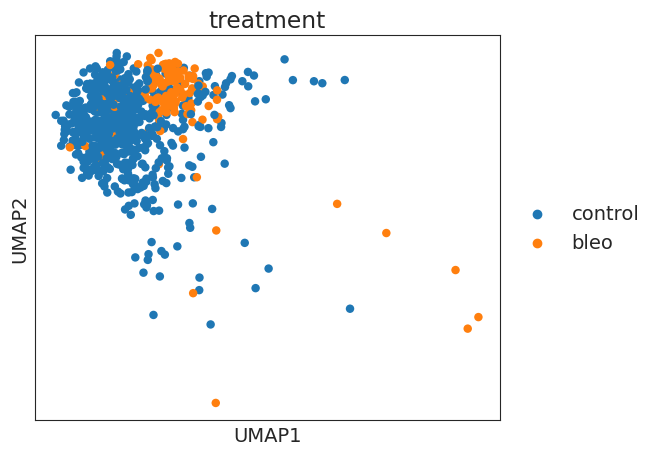

Started Diffxpy Calculation:	15-08-2024 10:17:26
training location model: True
training scale model: True
iter   0: ll=1131000.590579
caught 26 linalg singular matrix errors
iter   1: ll=1026731.273096, converged: 0.00% (loc: 1.01%, scale update: False), in 0.28sec
iter   2: ll=1002796.995452, converged: 0.00% (loc: 1.01%, scale update: False), in 0.29sec
iter   3: ll=1001484.929214, converged: 0.00% (loc: 1.01%, scale update: False), in 0.28sec
iter   4: ll=1001479.174936, converged: 0.00% (loc: 1.01%, scale update: False), in 0.27sec
iter   5: ll=1001479.171455, converged: 0.00% (loc: 20.87%, scale update: False), in 0.28sec
iter   6: ll=981682.005730, converged: 0.00% (loc: 0.00%, scale update: True), in 4.13sec
caught 26 linalg singular matrix errors
iter   7: ll=981660.662627, converged: 0.00% (loc: 1.08%, scale update: False), in 0.30sec
iter   8: ll=981660.612029, converged: 0.00% (loc: 13.36%, scale update: False), in 0.28sec
iter   9: ll=981660.611923, converged: 0.00% (loc: 8

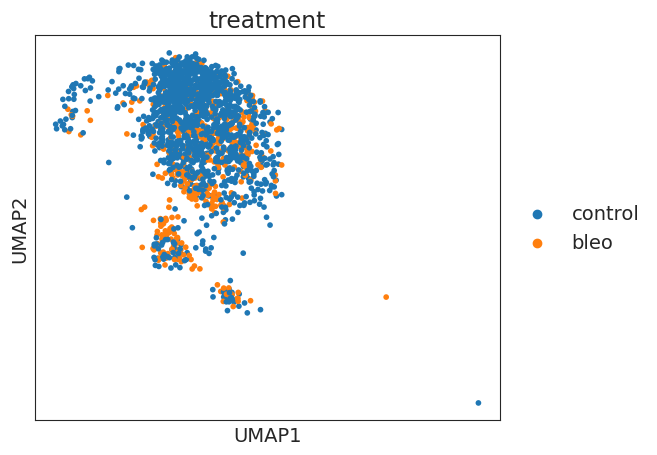

Started Diffxpy Calculation:	15-08-2024 10:17:52
training location model: True
training scale model: True
iter   0: ll=1893942.647098
iter   1: ll=1693277.138422, converged: 0.00% (loc: 0.00%, scale update: False), in 0.82sec
iter   2: ll=1643327.318465, converged: 0.00% (loc: 0.00%, scale update: False), in 1.19sec
iter   3: ll=1640237.296775, converged: 0.00% (loc: 0.00%, scale update: False), in 0.96sec
iter   4: ll=1640223.062242, converged: 0.00% (loc: 0.00%, scale update: False), in 1.30sec
iter   5: ll=1640223.059959, converged: 0.00% (loc: 20.46%, scale update: False), in 1.19sec
iter   6: ll=1610531.693870, converged: 0.00% (loc: 0.00%, scale update: True), in 7.64sec
iter   7: ll=1610518.464512, converged: 0.00% (loc: 0.00%, scale update: False), in 1.10sec
iter   8: ll=1610518.451886, converged: 0.00% (loc: 27.46%, scale update: False), in 0.78sec
iter   9: ll=1610518.451868, converged: 0.00% (loc: 97.21%, scale update: False), in 0.87sec
iter  10: ll=1610518.451868, converg

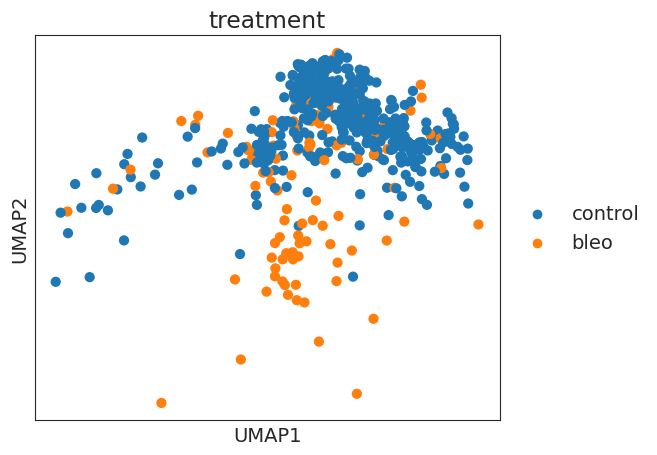

Started Diffxpy Calculation:	15-08-2024 10:18:26
training location model: True
training scale model: True
iter   0: ll=1148650.202808
caught 15 linalg singular matrix errors
iter   1: ll=1047465.598912, converged: 0.00% (loc: 0.37%, scale update: False), in 0.46sec
iter   2: ll=1023545.437421, converged: 0.00% (loc: 0.37%, scale update: False), in 1.32sec
iter   3: ll=1021878.755552, converged: 0.00% (loc: 0.37%, scale update: False), in 0.36sec
iter   4: ll=1021853.299702, converged: 0.00% (loc: 0.37%, scale update: False), in 0.37sec
iter   5: ll=1021852.897190, converged: 0.00% (loc: 1.50%, scale update: False), in 0.36sec
iter   6: ll=1007040.084524, converged: 0.00% (loc: 0.00%, scale update: True), in 4.79sec
caught 15 linalg singular matrix errors
iter   7: ll=1006912.353305, converged: 0.00% (loc: 0.47%, scale update: False), in 0.39sec
iter   8: ll=1006908.693330, converged: 0.00% (loc: 2.59%, scale update: False), in 0.37sec
iter   9: ll=1006908.536616, converged: 0.00% (loc:

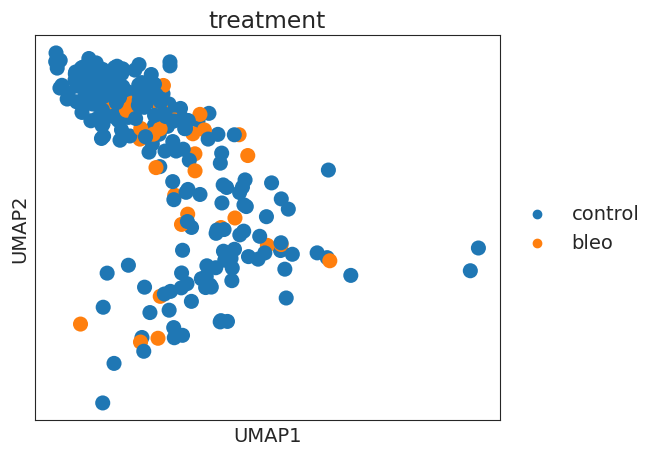

Started Diffxpy Calculation:	15-08-2024 10:19:13
training location model: True
training scale model: True
iter   0: ll=495253.514289
caught 373 linalg singular matrix errors
iter   1: ll=452631.905539, converged: 0.00% (loc: 9.24%, scale update: False), in 0.35sec
iter   2: ll=443167.051489, converged: 0.00% (loc: 9.24%, scale update: False), in 0.51sec
iter   3: ll=442636.084113, converged: 0.00% (loc: 9.24%, scale update: False), in 0.70sec
iter   4: ll=442631.861541, converged: 0.00% (loc: 9.24%, scale update: False), in 0.34sec
iter   5: ll=442631.833486, converged: 0.00% (loc: 23.37%, scale update: False), in 0.35sec
iter   6: ll=433136.892297, converged: 0.00% (loc: 0.00%, scale update: True), in 3.76sec
caught 373 linalg singular matrix errors
iter   7: ll=433090.638283, converged: 0.00% (loc: 9.29%, scale update: False), in 0.39sec
iter   8: ll=433089.076920, converged: 0.00% (loc: 13.04%, scale update: False), in 0.57sec
iter   9: ll=433089.061710, converged: 0.00% (loc: 48.67

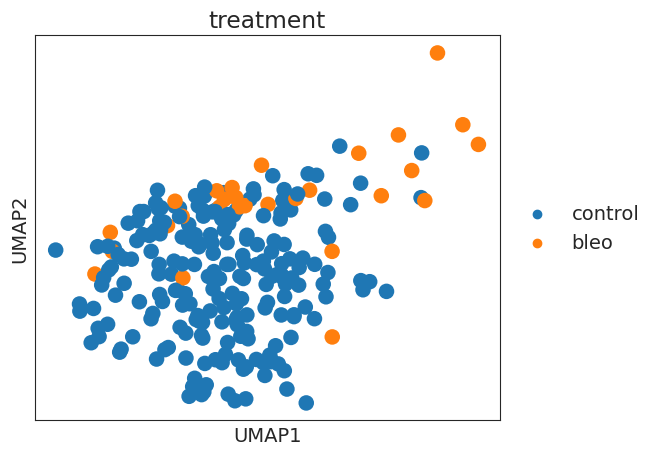

Started Diffxpy Calculation:	15-08-2024 10:19:54
training location model: True
training scale model: True
iter   0: ll=577255.122452
caught 866 linalg singular matrix errors
iter   1: ll=529291.898973, converged: 0.00% (loc: 22.38%, scale update: False), in 0.35sec
iter   2: ll=517694.282389, converged: 0.00% (loc: 22.38%, scale update: False), in 0.40sec
iter   3: ll=516834.597142, converged: 0.00% (loc: 22.38%, scale update: False), in 0.35sec
iter   4: ll=516820.560761, converged: 0.00% (loc: 22.38%, scale update: False), in 0.34sec
iter   5: ll=516820.438581, converged: 0.00% (loc: 22.94%, scale update: False), in 0.35sec
iter   6: ll=464524.769393, converged: 0.00% (loc: 0.00%, scale update: True), in 3.48sec
caught 866 linalg singular matrix errors
iter   7: ll=464386.529167, converged: 0.00% (loc: 22.25%, scale update: False), in 0.34sec
iter   8: ll=464381.843333, converged: 0.00% (loc: 23.69%, scale update: False), in 0.51sec
iter   9: ll=464381.727863, converged: 0.00% (loc: 

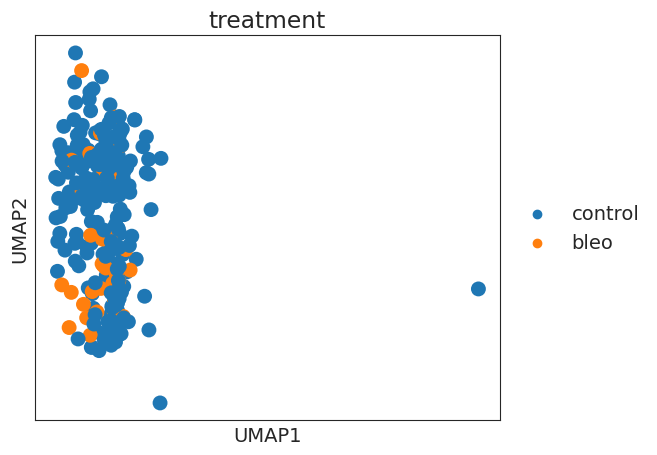

Started Diffxpy Calculation:	15-08-2024 10:20:42
training location model: True
training scale model: True
iter   0: ll=743834.830008
caught 176 linalg singular matrix errors
iter   1: ll=677992.802879, converged: 0.00% (loc: 4.82%, scale update: False), in 0.75sec
iter   2: ll=661849.873753, converged: 0.00% (loc: 4.82%, scale update: False), in 0.84sec
iter   3: ll=660469.154711, converged: 0.00% (loc: 4.82%, scale update: False), in 0.83sec
iter   4: ll=660424.907718, converged: 0.00% (loc: 4.82%, scale update: False), in 0.55sec
iter   5: ll=660422.736927, converged: 0.00% (loc: 4.91%, scale update: False), in 0.41sec
iter   6: ll=543873.734282, converged: 0.00% (loc: 0.00%, scale update: True), in 4.29sec
caught 176 linalg singular matrix errors
iter   7: ll=543439.992355, converged: 0.00% (loc: 4.23%, scale update: False), in 0.44sec
iter   8: ll=543384.609269, converged: 0.00% (loc: 5.26%, scale update: False), in 0.37sec
iter   9: ll=543379.887008, converged: 0.00% (loc: 11.54%,

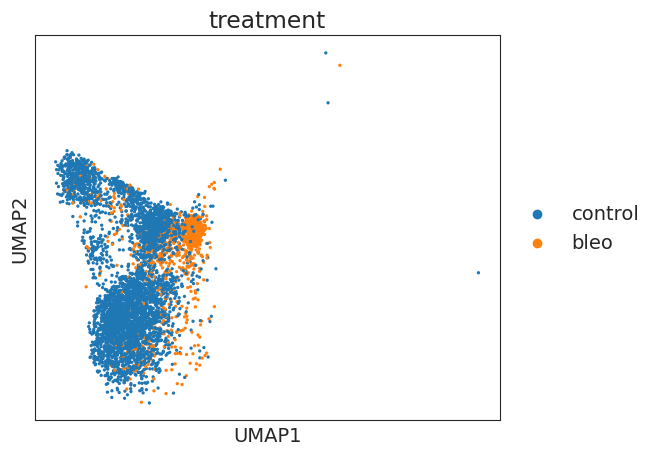

Started Diffxpy Calculation:	15-08-2024 10:21:44
training location model: True
training scale model: True
iter   0: ll=9375525.913144
iter   1: ll=8572336.794207, converged: 0.00% (loc: 0.00%, scale update: False), in 1.74sec
iter   2: ll=8384141.598786, converged: 0.00% (loc: 0.00%, scale update: False), in 2.99sec
iter   3: ll=8373426.154148, converged: 0.00% (loc: 0.00%, scale update: False), in 3.33sec
iter   4: ll=8373379.136064, converged: 0.00% (loc: 0.00%, scale update: False), in 2.79sec
iter   5: ll=8373379.068101, converged: 0.00% (loc: 14.68%, scale update: False), in 2.47sec
iter   6: ll=8168912.702462, converged: 0.00% (loc: 0.00%, scale update: True), in 22.65sec
iter   7: ll=8168626.189148, converged: 0.00% (loc: 0.00%, scale update: False), in 2.54sec
iter   8: ll=8168625.076519, converged: 0.00% (loc: 3.87%, scale update: False), in 3.12sec
iter   9: ll=8168625.065602, converged: 0.00% (loc: 56.76%, scale update: False), in 2.41sec
iter  10: ll=8168625.065382, converg

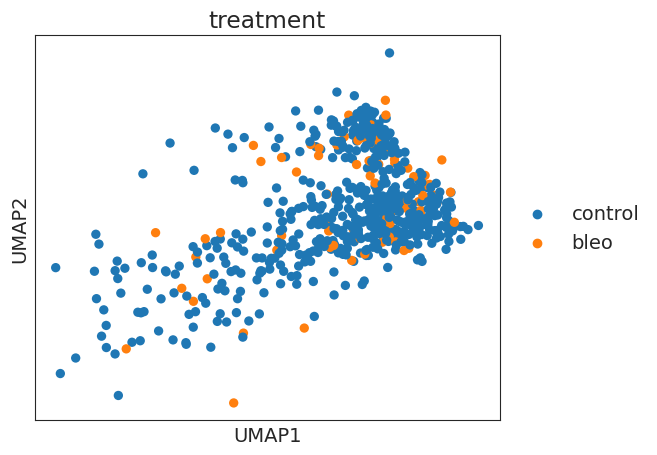

Started Diffxpy Calculation:	15-08-2024 10:23:41
training location model: True
training scale model: True
iter   0: ll=1608031.207768
caught 14 linalg singular matrix errors
iter   1: ll=1459487.919359, converged: 0.00% (loc: 0.38%, scale update: False), in 0.39sec
iter   2: ll=1424237.975827, converged: 0.00% (loc: 0.38%, scale update: False), in 0.40sec
iter   3: ll=1421785.781878, converged: 0.00% (loc: 0.38%, scale update: False), in 0.39sec
iter   4: ll=1421754.540939, converged: 0.00% (loc: 0.38%, scale update: False), in 0.39sec
iter   5: ll=1421754.298732, converged: 0.00% (loc: 1.36%, scale update: False), in 0.61sec
iter   6: ll=1393556.912312, converged: 0.00% (loc: 0.00%, scale update: True), in 5.53sec
caught 14 linalg singular matrix errors
iter   7: ll=1393291.367544, converged: 0.00% (loc: 0.38%, scale update: False), in 0.39sec
iter   8: ll=1393279.883947, converged: 0.00% (loc: 2.53%, scale update: False), in 0.39sec
iter   9: ll=1393279.779360, converged: 0.00% (loc:

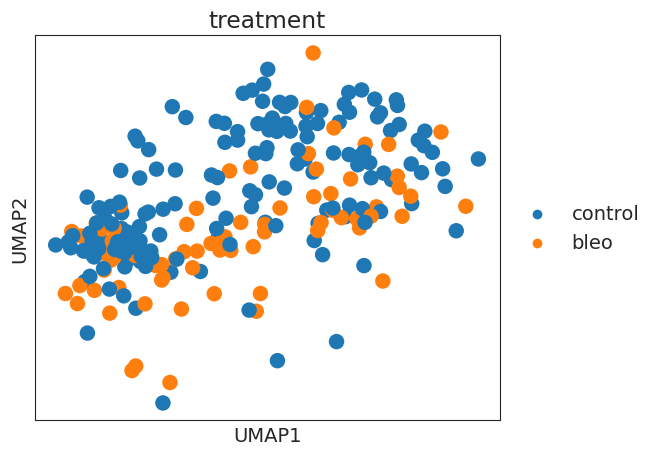

Started Diffxpy Calculation:	15-08-2024 10:24:23
training location model: True
training scale model: True
iter   0: ll=769706.935145
caught 60 linalg singular matrix errors
iter   1: ll=711568.186908, converged: 0.00% (loc: 2.15%, scale update: False), in 0.41sec
iter   2: ll=698178.008343, converged: 0.00% (loc: 2.15%, scale update: False), in 0.57sec
iter   3: ll=697243.255088, converged: 0.00% (loc: 2.15%, scale update: False), in 0.46sec
iter   4: ll=697227.543573, converged: 0.00% (loc: 2.15%, scale update: False), in 0.45sec
iter   5: ll=697227.270073, converged: 0.00% (loc: 3.93%, scale update: False), in 0.46sec
iter   6: ll=526184.701055, converged: 0.00% (loc: 0.00%, scale update: True), in 4.59sec
caught 60 linalg singular matrix errors
iter   7: ll=525842.680766, converged: 0.00% (loc: 1.74%, scale update: False), in 0.42sec
iter   8: ll=525820.449351, converged: 0.00% (loc: 2.97%, scale update: False), in 0.40sec
iter   9: ll=525819.727599, converged: 0.00% (loc: 13.91%, s

In [28]:
subset = ["control", "bleo"]
condition = "treatment"
ct_label = "meta_label"
min_cells = 10

time = "d37"
time_subset = adata[adata.obs.time_point.isin([time, "d0"])].copy()
sc.pl.umap(time_subset, color = ["day", "meta_label"], size = 10, wspace = 0.25)

for ct in cell_types:
    
    print("%s - %s" %(ct, time))
    dge(time_subset, ct = ct, ct_label = ct_label, condition = condition, ref = "control", pct_thresh = 0.05,
              subset = subset, min_cells = min_cells, do_return = False, suffix = "_young")